# Classification benchmark: PLN-Tree

In [1]:
from plntree.models import PLNTreeMixtureClassifier, PLNTree
from plntree.utils.classifiers import DenseClassifier, RNNClassifier
from plntree.utils.jupyter_functions import *
from plntree.data.utils import numpy_dataset_to_torch_dataloader
import torch
import torch.optim as optim

2024-10-08 16:14:17.103693: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-08 16:14:17.133474: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-08 16:14:17.298521: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-08 16:14:17.298582: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-08 16:14:17.326780: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

# Metagenomics dataset

## Dataset import

In [2]:
seed = 0
# Select the taxonomic precision
precision = 'f'
prefix = f'metagenomics_classification_taxaL{precision}_s{seed}'

seed_all(seed)

In [3]:
from plntree.data import metagenomics_loader

raw_abundances, metadata = metagenomics_loader.load_raw_data(directory='./plntree/data/metagenomics')

In [4]:
diseases = ['t2d', 'ibd_ulcerative_colitis', 'cirrhosis', 'ibd_crohn_disease', 'cancer', 'obesity', 'leaness']
raw_abundances, metadata = metagenomics_loader.filter_diseases(raw_abundances, metadata, diseases)

In [5]:
# Filter out some taxa
filtered_taxa = ['k__Archaea', 'k__Eukaryota']
# Select the rarefaction offset
rarefaction_offset = 12
# Select the prevalence threshold (-1 for none)
prevalence = 1 / np.exp(rarefaction_offset)

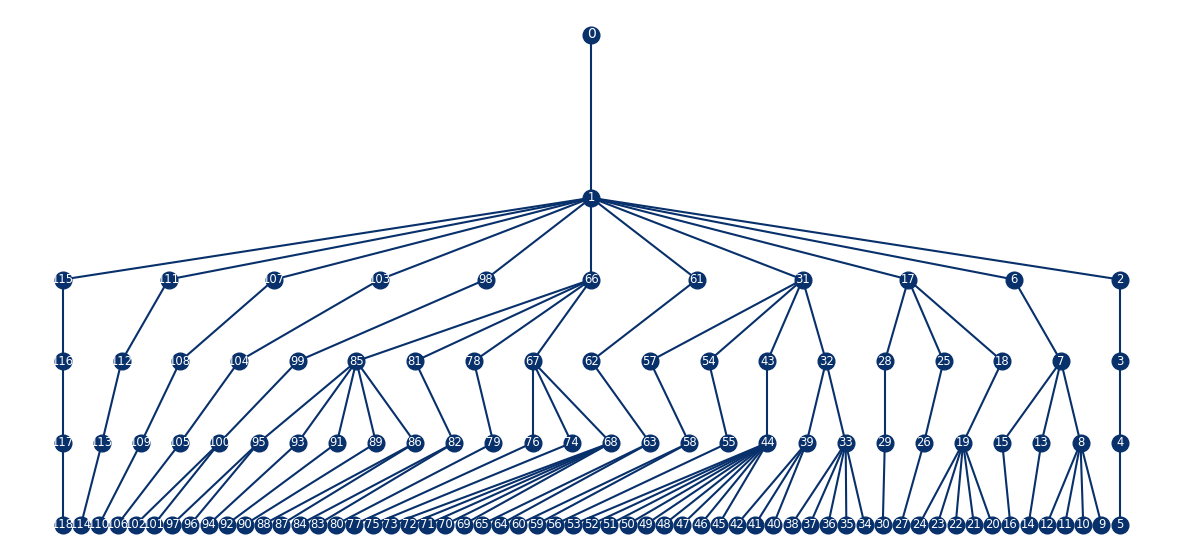

In [6]:
abundances = metagenomics_loader.raw_abundance_filter(raw_abundances, precision)
for taxon in filtered_taxa:
    abundances = metagenomics_loader.exclude_taxon(abundances, taxon)
if prevalence > 0:
    abundances = metagenomics_loader.prevalence_filter(abundances, threshold=prevalence)
abundances = metagenomics_loader.rarefy(abundances, rarefaction_offset, seed=seed)

taxonomy = metagenomics_loader.get_taxonomy(abundances)
taxonomy.plot(legend=False, title='')

In [7]:
from torch.utils.data import DataLoader, TensorDataset
# Select the offset layer
selected_layers = [2, -1]
K = list(taxonomy.getLayersWidth().values())[selected_layers[0]:]
X_base, patient_ids = metagenomics_loader.hierarchical_dataset(abundances, taxonomy, offset_layer=selected_layers[0])

# Select the batch size
batch_size = len(X_base)
seed_all(seed)
dataset = TensorDataset(X_base.to(dtype=torch.float64), X_base.to(dtype=torch.float64))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

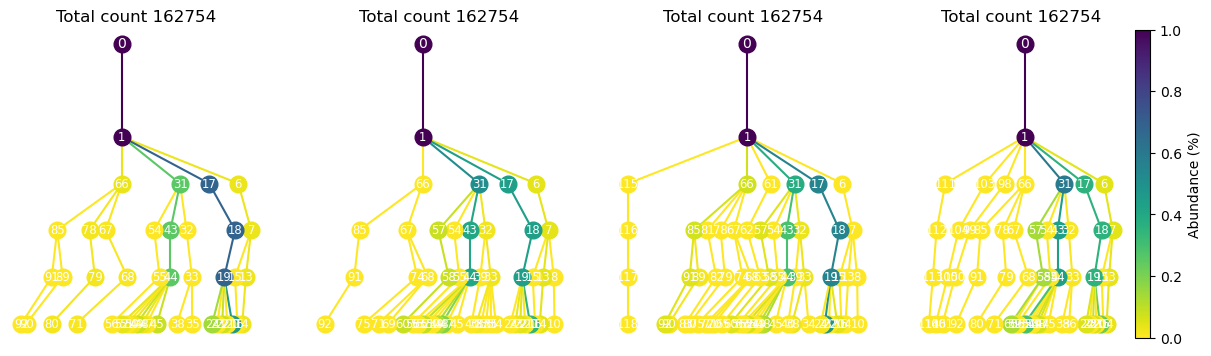

In [8]:
vizualize_samples(dataloader, taxonomy, autofill=True, seed=seed)
savefig('metagenomics_samples')

## Visualize the problem's difficulty with PCA

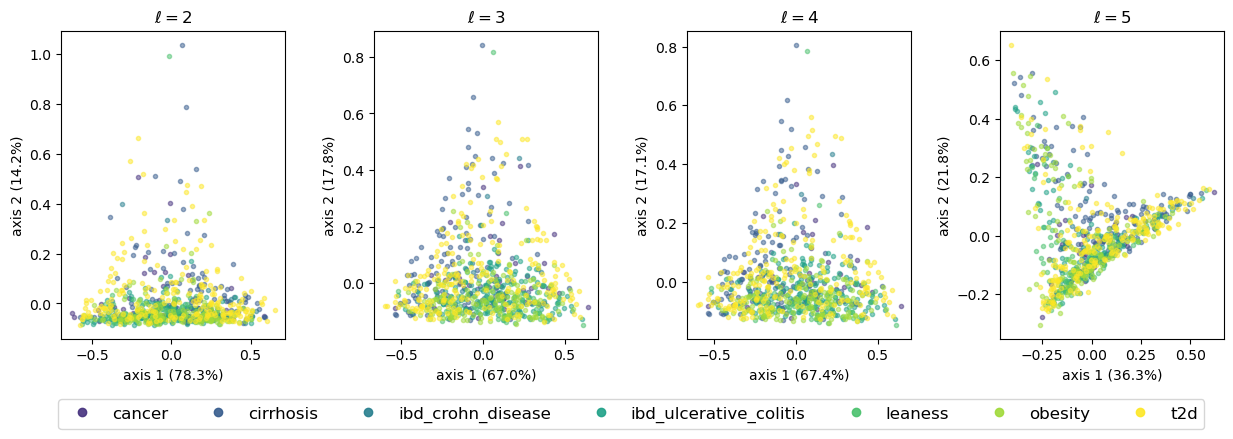

In [9]:
from sklearn.decomposition import PCA
import matplotlib.lines as mlines
import matplotlib

Y_base = metadata['disease']
def plot_pca(Y_base, X_base):
    fig, axs = plt.subplots(1, len(K), figsize=(15, 4))
    colors = [matplotlib.cm.get_cmap('viridis')((i+1)/len(np.unique(Y_base))) for i, name in enumerate(np.unique(Y_base))]
    for layer, K_l in enumerate(K):
        X_l = X_base[:, layer, :K_l]
        pca = PCA(n_components=2, random_state=seed).fit(X_l)
        X_l_pca = pca.transform(X_l)
        for k, c in enumerate(np.unique(Y_base)):
            indexes = np.where(Y_base == c)
            axs[layer].set_title(f'$\ell = {layer + selected_layers[0]}$')
            axs[layer].plot(X_l_pca[indexes, 0], X_l_pca[indexes, 1], marker='.', linestyle='', color=colors[k], alpha=0.5)
            axs[layer].set_xlabel(f'axis 1 ({np.round(pca.explained_variance_ratio_[0] * 100, 1)}%)')
            axs[layer].set_ylabel(f'axis 2 ({np.round(pca.explained_variance_ratio_[1] * 100, 1)}%)')
    legend_handles = [
            mlines.Line2D([], [], marker='o', linestyle='', color=color, alpha=0.9, label=group)
            for color, group in zip(colors, np.unique(Y_base))
        ]
    legend = plt.legend(handles=legend_handles, fontsize="12", loc='lower center', bbox_to_anchor=(-1.65, -0.32), ncols=len(colors))
    plt.subplots_adjust(wspace=0.4)
plot_pca(Y_base, X_base / X_base[:, 0].sum(dim=-1, keepdims=True).unsqueeze(-1))
savefig(f'{prefix}_PCA_all_diseases')

In [10]:
n_classes = len(np.unique(Y_base))
n_classes

7

In [11]:
print(np.unique(Y_base, return_counts=True))

(array(['cancer', 'cirrhosis', 'ibd_crohn_disease',
       'ibd_ulcerative_colitis', 'leaness', 'obesity', 't2d'],
      dtype=object), array([ 48, 118,  25, 148,  89, 164, 223]))


## Preprocessing using PLN models

Setting the offsets as the log of the sum of endog
Fitting a Pln model with full covariance model.
Initialization ...
Initialization finished
Tolerance 1e-08 reached in 901 iterations
Setting the offsets as the log of the sum of endog
Fitting a Pln model with full covariance model.
Initialization ...
Initialization finished
Tolerance 1e-08 reached in 909 iterations
Setting the offsets as the log of the sum of endog
Fitting a Pln model with full covariance model.
Initialization ...
Initialization finished
Tolerance 1e-08 reached in 899 iterations
Setting the offsets as the log of the sum of endog
Fitting a Pln model with full covariance model.
Initialization ...
Initialization finished
Tolerance 1e-08 reached in 863 iterations
Likelihood: -45823.94618344307


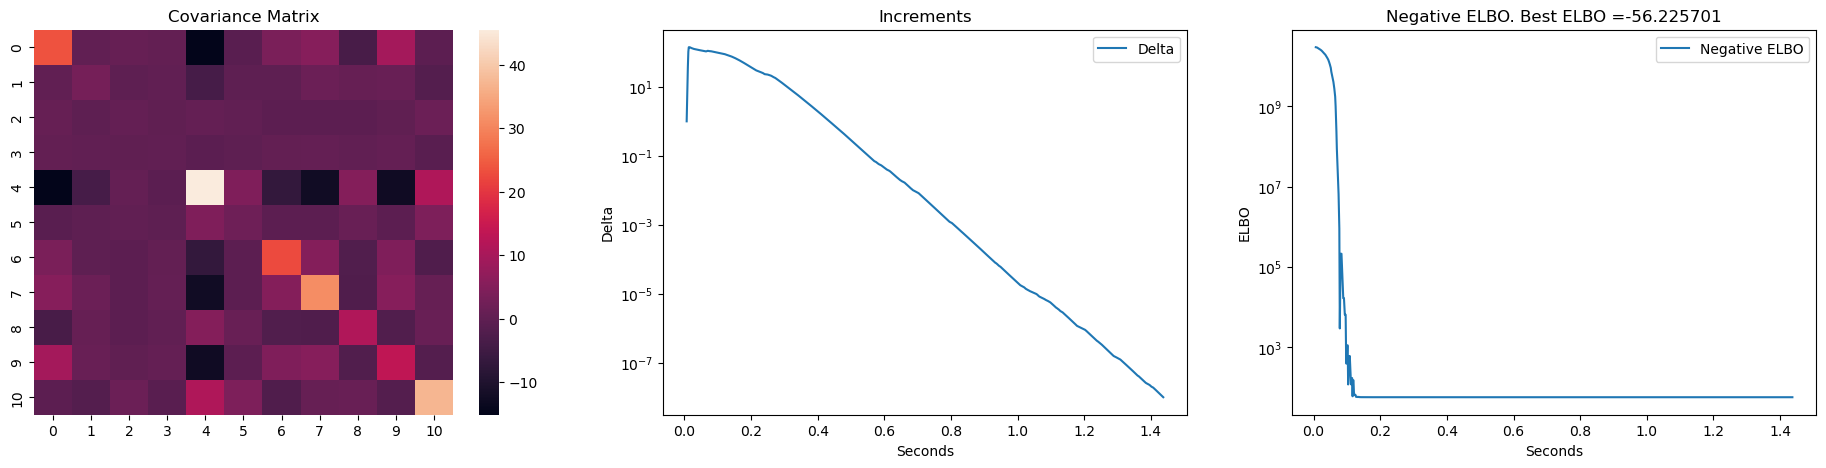

Likelihood: -81056.42355322838


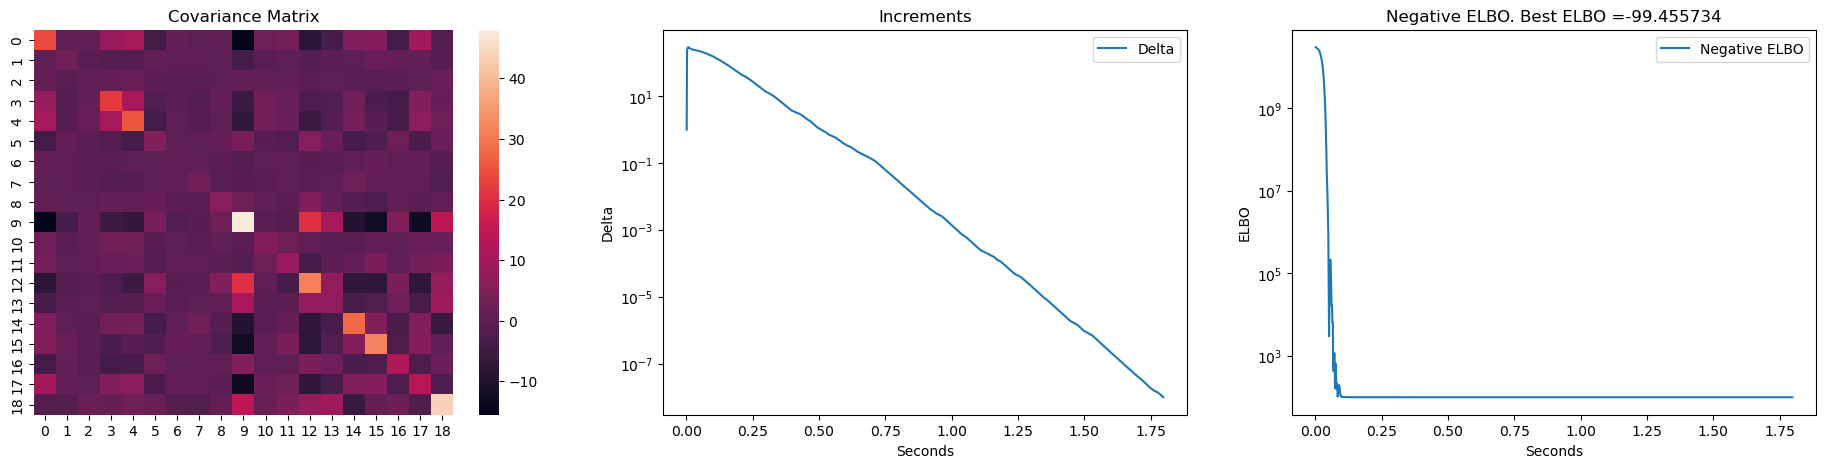

Likelihood: -96048.11932015419


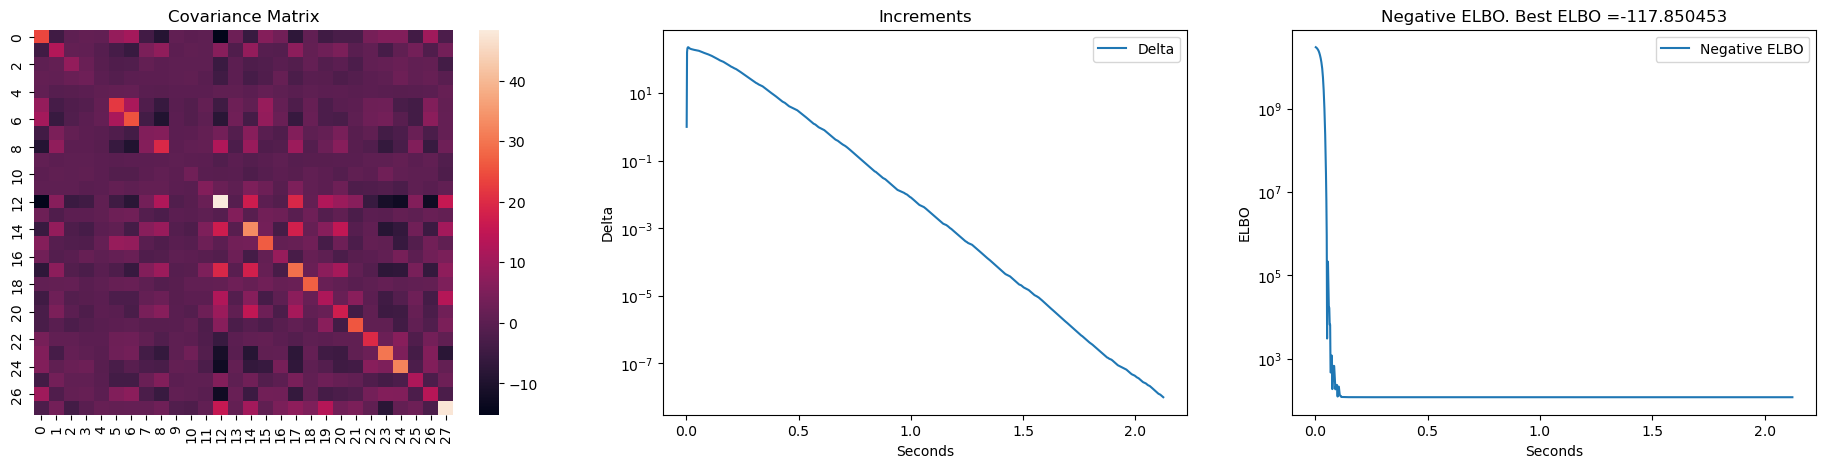

Likelihood: -182364.10521793365


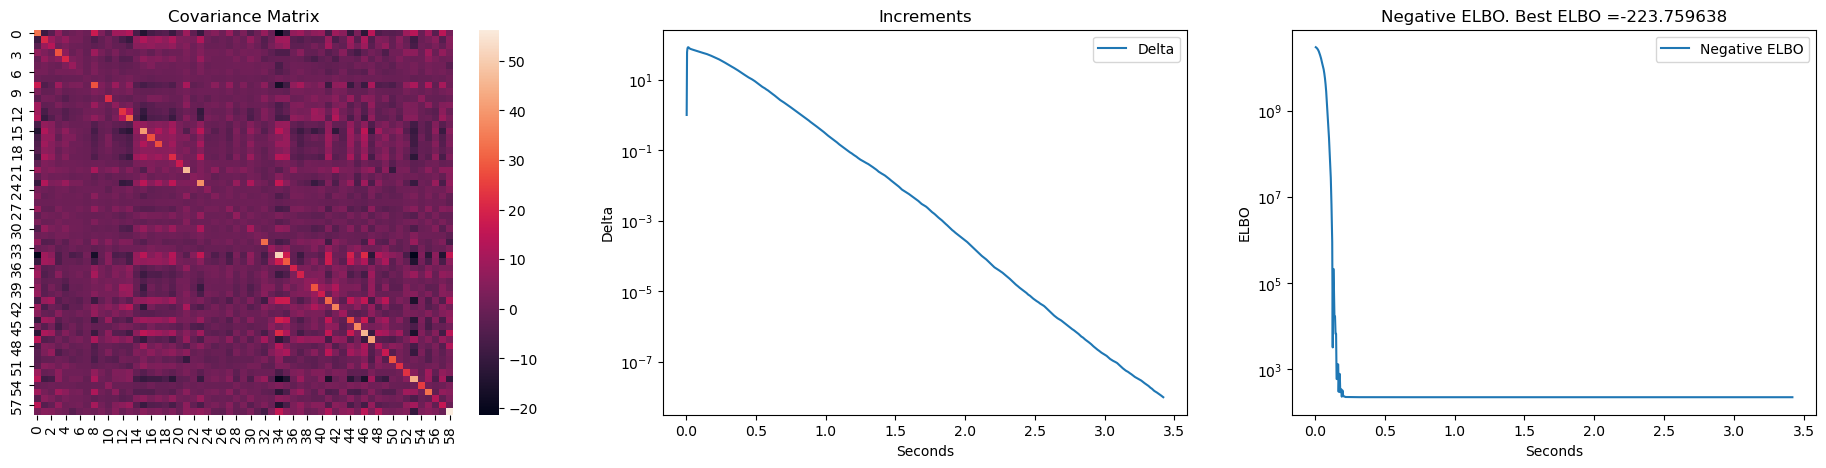

In [12]:
pln_layers = learn_pln(X_base, K, seed=seed)

In [13]:
def get_plntree_params_and_suffix(n_latent_layers, variational_approx, variational_approx_params):
    params = {
        'tree':taxonomy,
        'selected_layers':selected_layers,
        'diagonal_model':False,
        'variational_approx':variational_approx,
        'positive_fun':'softplus',
        'offset_method':'constant',
        'variational_approx_params':variational_approx_params,
        'n_latent_layers':n_latent_layers,
        'diag_smoothing_factor':1e-4
    }
    placeholder = variational_approx_params
    if variational_approx == 'mean_field':
        placeholder = variational_approx_params['n_variational_layers']
    suffix = f'latentlayers-{n_latent_layers}_varlayers-{placeholder}'
    return params, suffix

def learn_plntree_mean_field(params):
    estimator = PLNTree(**params, seed=seed)

    optimizer = optim.Adam(
        estimator.parameters(),
        lr=1e-3,
    )
    n_epoch = 30_000
    return estimator.fit(optimizer, dataloader, n_epoch=n_epoch, verbose=100, max_grad_norm=10.)

n_latent_layers = 1
n_variational_layers = 3
preprocessing = 'proportion'
print('Latents size', n_latent_layers)
print('Variational size', n_variational_layers)
variational_approx_params = {
    'n_variational_layers':n_variational_layers,
    'preprocessing': [preprocessing]
}
params, suffix = get_plntree_params_and_suffix(n_latent_layers, 'mean_field', variational_approx_params)
try:
    meanfield, meanfield_losses = load_pkl(prefix, f'mean_field_{preprocessing}_{suffix}')
except:
    meanfield, meanfield_losses = learn_plntree_mean_field(params)
    save_pkl((meanfield, meanfield_losses), prefix, f'mean_field_{preprocessing}_{suffix}')

Latents size 1
Variational size 3
Loading file ./experiments/saves/metagenomics_classification_taxaLf_s0_mean_field_proportion_latentlayers-1_varlayers-3.pkl


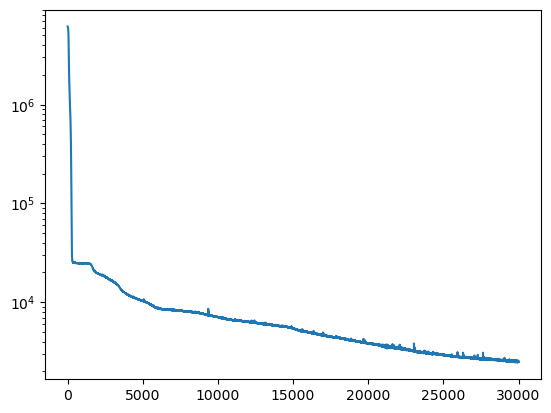

In [14]:
fig, axs = plt.subplots()
axs.plot(meanfield_losses)
axs.set_yscale('log')

In [15]:
preprocessing = 'proportion'
def learn_plntree(n_latent_layers, variational_approx, variational_approx_params):
    estimator = PLNTree(
        tree=taxonomy,
        selected_layers=selected_layers,
        diag_smoothing_factor=1e-4,
        positive_fun='softplus',
        offset_method='constant',
        identifiable=True,
        variational_approx=variational_approx,
        variational_approx_params=variational_approx_params,
        n_latent_layers=n_latent_layers,
        seed=seed
    )
    optimizer = optim.Adam(
        estimator.parameters(),
        lr=1e-3,
    )
    estimator.to(dtype=torch.float64)
    n_epoch = 30_000
    return estimator.fit(optimizer, dataloader, n_epoch=n_epoch, verbose=100, max_grad_norm=5.)

def embedder_params(embedder_type='GRU', embedding_size=16, n_embedding_layers=2, n_embedding_neurons=32, n_after_layers=2):
    params = {
        'embedder_type': embedder_type,
        'embedding_size': embedding_size,
        'n_embedding_layers': n_embedding_layers,
        'n_embedding_neurons': n_embedding_neurons,
        'n_after_layers': n_after_layers,
        'preprocessing': ['proportion']
    }
    name = f'Emb{embedder_type}-{n_embedding_layers}x{n_embedding_neurons}to{embedding_size}-{n_after_layers}'
    return name, params

n_latent_layers = 1
emb_name, variational_approx_params = embedder_params(
    embedding_size=32,
    n_embedding_layers=2,
    n_embedding_neurons=64,
    n_after_layers=2
)
try:
    backward, backward_losses = load_pkl(prefix, f'residual_backward_{preprocessing}_{n_latent_layers}-{emb_name}')
except:
    print('Learning PLN-Tree (residual backward)')
    print(variational_approx_params)
    backward, backward_losses = learn_plntree(n_latent_layers, 'residual_backward', variational_approx_params)
    save_pkl((backward, backward_losses), prefix, f'residual_backward_{preprocessing}_{n_latent_layers}-{emb_name}')

Loading file ./experiments/saves/metagenomics_classification_taxaLf_s0_residual_backward_proportion_1-EmbGRU-2x64to32-2.pkl


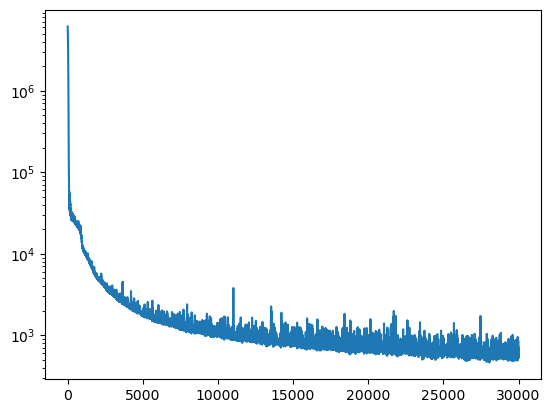

In [16]:
fig, axs = plt.subplots()
axs.plot(backward_losses)
axs.set_yscale('log')

In [17]:
Z_meanfield, O_meanfield = meanfield.encode(X_base, seed=42)
Z_backward, O_backward = backward.encode(X_base, seed=42)

In [18]:
Z_meanfield = meanfield.identify(Z_meanfield)
Z_backward = backward.identify(Z_backward)

In [19]:
Z_pln_enc = generate_pln_data(pln_layers, 1, K, selected_layers, X_base, taxonomy, seed=seed)[-2]

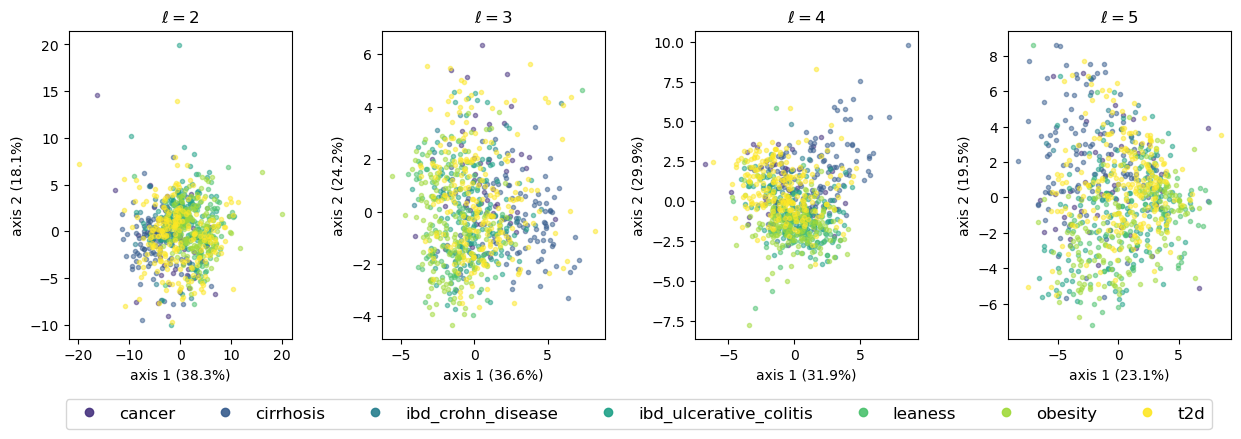

In [20]:
from sklearn.decomposition import PCA
import matplotlib.lines as mlines
import matplotlib

Y_base = metadata['disease'].copy()
prefix_labels = 'all_diseases-'
plot_pca(Y_base, Z_backward.detach())

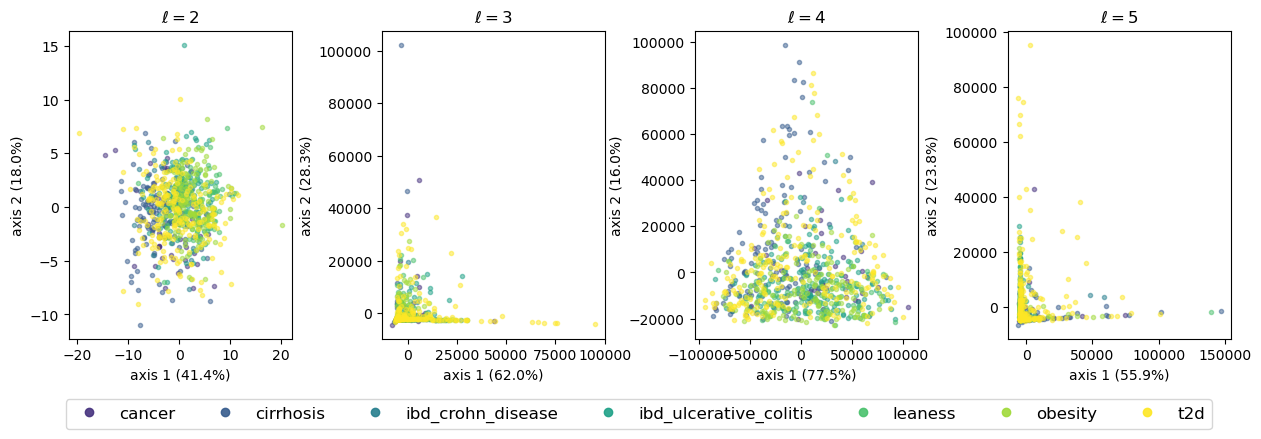

In [21]:
from sklearn.decomposition import PCA
import matplotlib.lines as mlines
import matplotlib

Y_base = metadata['disease'].copy()
prefix_labels = 'all_diseases-'
Z_plot = backward.latent_clr(Z_backward).detach()
plot_pca(Y_base, Z_plot)
savefig(f'{prefix}_PCA_all_diseases_latent_allocation')

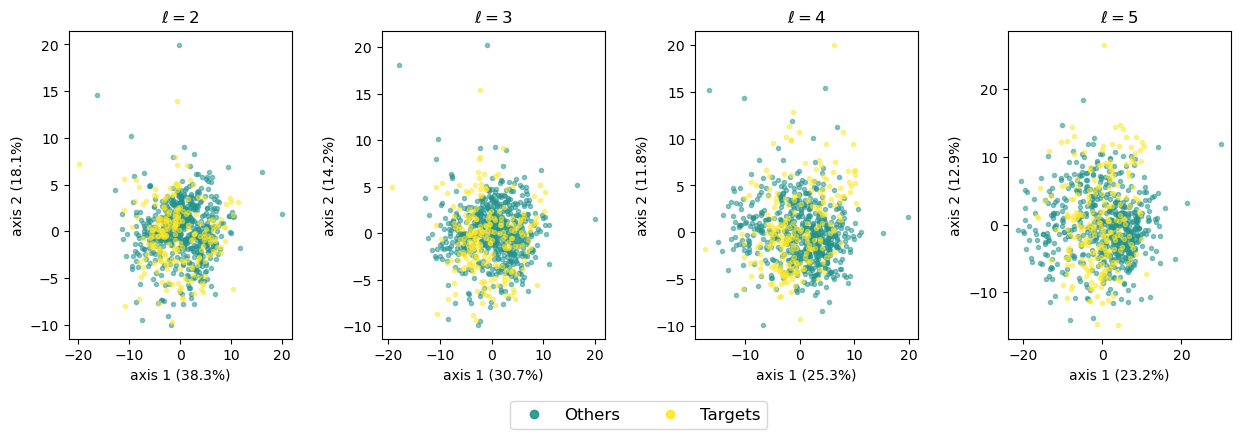

In [23]:
from sklearn.decomposition import PCA
import matplotlib.lines as mlines
import matplotlib

scenario = 't2d'

if scenario == 'ibd':
    filtered_labels = ['ibd_crohn_disease', 'ibd_ulcerative_colitis']
elif scenario == 'cirrhosis':
    filtered_labels = ['cirrhosis']
elif scenario == 'obesity':
    filtered_labels = ['obesity']
elif scenario == 'colorectal':
    filtered_labels = ['cancer']
elif scenario == 'leaness':
    filtered_labels = ['leaness']
elif scenario == 't2d':
    filtered_labels = ['t2d']
elif scenario == 't2d_obe':
    filtered_labels = ['t2d', 'obesity']
elif scenario == 'cirr_col':
    filtered_labels = ['cirrhosis', 'colorectal']
prefix_labels = ''
for label in filtered_labels:
    prefix_labels += f'-{label}'
Y_base = metadata['disease'].copy()
for i in range(len(Y_base)):
    if Y_base[i] not in filtered_labels:
        Y_base[i] = 'Others'
    else:
        Y_base[i] = 'Targets'

plot_pca(Y_base, torch.log(backward.latent_tree_counts(Z_backward)).detach())

In [24]:
n_classes = len(np.unique(Y_base))
n_classes

2

In [25]:
print(np.unique(Y_base, return_counts=True))

(array(['Others', 'Targets'], dtype=object), array([592, 223]))


## Benchmark models

In [26]:
from sklearn.model_selection import StratifiedShuffleSplit

def train_test(X, y, train_indexes, test_indexes):
    X_train, y_train = X[train_indexes], y[train_indexes]
    X_test, y_test = X[test_indexes], y[test_indexes]
    return X_train, y_train, X_test, y_test

def bootstrap_train(X, y, model, params, n_repeats=10, train_size=0.8, seed=None, verbose=False):
    seed_all(seed)
    models = []
    indexes = np.arange(0, len(X))
    for i, (train_indexes, test_indexes) in enumerate(StratifiedShuffleSplit(n_splits=n_repeats, train_size=train_size).split(X, y)):
        X_train, y_train, X_test, y_test = train_test(X, y, train_indexes, test_indexes)
        assert((np.unique(y_train) == np.unique(y_test)).all())
        if verbose:
            print(f'Fitting Fold {i}...')
        benchmark = model(**params).fit(X_train, y_train)
        models.append((benchmark, train_indexes, test_indexes))
    return models

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, balanced_accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc, average_precision_score, RocCurveDisplay
import pandas as pd
from scipy import interp
from scipy.stats import mstats
import math

def performances(X, y, benchmarks, predict_args=None):
    if predict_args is None:
        predict_args = {}
    metrics = {
        'accuracy':accuracy_score,
        'precision':lambda y_test, y_pred: precision_score(y_test, y_pred, average='weighted'),
        'recall':lambda y_test, y_pred: recall_score(y_test, y_pred, average='weighted'),
        'F1':lambda y_test, y_pred: f1_score(y_test, y_pred, average='weighted'),
        'balanced accuracy':balanced_accuracy_score,
    }
    results = {f'{key}':[] for key in metrics}
    conf_matrices = []
    auc_args = []
    pr_args = []
    auc_values = []
    auc_pr_values = []
    pr_values = []
    for model, train_indexes, test_indexes in benchmarks:
        X_train, y_train, X_test, y_test = train_test(X, y, train_indexes, test_indexes)
        y_proba = model.predict_proba(X_test, **predict_args)
        if len(predict_args) == 0:
            y_pred = model.predict(X_test)
        else:
            y_pred = model.predict(X_test, predict_args)
        for metric, metric_fun in metrics.items():
            results[metric].append(metric_fun(y_test, y_pred))
            
        conf_matrices.append(confusion_matrix(y_test, y_pred))
        
        if len(np.unique(y)) == 2:
            fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1])
            base_fpr = np.linspace(0, 1, 101)
            tpr_interp = interp(base_fpr, fpr, tpr)
            tpr_interp[0] = 0.0
            auc_args.append(tpr_interp)
            auc_values.append(auc(fpr, tpr))
            
            precisions, recalls, pr_thresh = precision_recall_curve(y_test, y_proba[:, 1])
            base_recalls = np.linspace(0, 1, 101)
            pre_interp = interp(base_recalls, np.flip(recalls), np.flip(precisions))
            pre_interp[0] = np.flip(precisions)[0]
            pr_args.append(pre_interp)
            auc_pr_values.append(auc(recalls, precisions))
            pr_values.append(average_precision_score(y_test, y_proba[:, 1]))
    if len(auc_values) > 0:
        results['ROC AUC'] = auc_values
    if len(pr_values) > 0:
        results['PR AUC'] = auc_pr_values
        results['Averaged Precision'] = pr_values
    return results, conf_matrices, auc_args, pr_args

def performances_summary(X, y, benchmarks, name, predict_args=None, percentile=0.05):
    np.set_printoptions(suppress=True)
    results, conf_matrices, auc_args = performances(X, y, benchmarks, predict_args)
    print(f'------- Model summary {name} -------')
    for metric, res in results.items():
        print(f'{metric}:', np.round(np.mean(res), decimals=3), f'({np.round(np.std(res), decimals=3)})')
    cm = 0
    for matrix in conf_matrices:
        cm += matrix
    print('Mean normalized confusion matrix:')
    cm = cm / cm.sum(axis=1)[:, np.newaxis]
    labels = np.unique(y)
    if len(auc_args) > 0:
        fig, axs = plt.subplots()
        base_fpr = np.linspace(0, 1, 101)
        axs.plot([0, 1], [0, 1], color="navy", linestyle="--")
        axs.set_xlim([-0.01, 1.0])
        axs.set_ylim([-0.01, 1.05])
        axs.set_ylabel('True positive rate', fontsize=12)
        axs.set_xlabel('False positive rate', fontsize=12)
        axs.tick_params(labelright=True)
        axs.grid('True')

        roc_tpr_array = np.array(auc_args)
        for i in range(len(roc_tpr_array)):
            for j in range(roc_tpr_array.shape[1]):
                if math.isnan(roc_tpr_array[i][j]):
                    roc_tpr_array[i][j] = 0
        mean_tprs = roc_tpr_array.mean(axis=0)
        std_tprs = roc_tpr_array.std(axis=0)
        axs.plot(base_fpr, mean_tprs, 'b', label="Mean")
        
        quantiles = mstats.mquantiles(roc_tpr_array, prob=[percentile, 1-percentile], axis=0)
        axs.fill_between(base_fpr, quantiles[0], quantiles[1], color='b', alpha=0.1, label=f"CI {int(100*(1-percentile))}%")
        axs.legend()
    return pd.DataFrame(index=labels, columns=labels, data=cm).round(2)

In [28]:
import matplotlib
def multiple_performances_summary(X_dic, y, model, params, n_repeats=50, train_size=0.8, percentile=0.05, save_name=None, seed=None, verbose=False):
    df = None
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].plot([0, 1], [0, 1], color="navy", linestyle="--")
    axs[1].plot([0, 1], [0.5, 0.5], color="navy", linestyle="--")
    colors = [matplotlib.cm.get_cmap('plasma')(1e-8 + (i+1)/(len(X_dic)+.5)) for i in range(len(X_dic))]
    for k, (name, X) in enumerate(X_dic.items()):
        benchmarks = bootstrap_train(
            X, y,
            model, params,
            seed=seed,
            n_repeats=n_repeats
        )
        np.set_printoptions(suppress=True)
        results, conf_matrices, auc_args, pre_args = performances(X, y, benchmarks)
        inputs = []
        metrics = []
        for metric, res in results.items():
            inputs.append(f'{np.round(np.mean(res), decimals=3)} ({np.round(np.std(res), decimals=3)})')
            metrics.append(metric)
        if df is None:
            df = pd.DataFrame(columns=metrics)
        df.loc[name] = inputs
        if len(auc_args) > 0:
            base_fpr = np.linspace(0, 1, 101)
            axs[0].set_xlim([-0.01, 1.0])
            axs[0].set_ylim([-0.01, 1.05])
            axs[0].set_ylabel('True positive rate', fontsize=12)
            axs[0].set_xlabel('False positive rate', fontsize=12)

            roc_tpr_array = np.array(auc_args)
            for i in range(len(roc_tpr_array)):
                for j in range(roc_tpr_array.shape[1]):
                    if math.isnan(roc_tpr_array[i][j]):
                        roc_tpr_array[i][j] = 0
            mean_tprs = roc_tpr_array.mean(axis=0)
            std_tprs = roc_tpr_array.std(axis=0)
            axs[0].plot(base_fpr, mean_tprs, color=colors[k], label=name, alpha=0.7)

            quantiles = mstats.mquantiles(roc_tpr_array, prob=[percentile, 1-percentile], axis=0)
            axs[0].fill_between(base_fpr, quantiles[0], quantiles[1], color=colors[k], alpha=0.1)
        if len(pre_args) > 0:
            base_recalls = np.linspace(0, 1, 101)
            axs[1].set_xlim([-0.01, 1.0])
            axs[1].set_ylim([-0.01, 1.05])
            axs[1].set_ylabel('Precision', fontsize=12)
            axs[1].set_xlabel('Recall', fontsize=12)

            precisions = np.array(pre_args)
            for i in range(len(precisions)):
                for j in range(precisions.shape[1]):
                    if math.isnan(precisions[i][j]):
                        precisions[i][j] = 0.
            mean_precisions = precisions.mean(axis=0)
            std_precisions = precisions.std(axis=0)
            axs[1].plot(base_recalls, mean_precisions, color=colors[k], label=name, alpha=0.7)

            quantiles = mstats.mquantiles(precisions, prob=[percentile, 1-percentile], axis=0)
            axs[1].fill_between(base_recalls, quantiles[0], quantiles[1], color=colors[k], alpha=0.1)
    #axs[0].legend()
    axs[0].grid('True')
    axs[1].legend()
    axs[1].grid('True')
    plt.tight_layout()
    if save_name is not None:
        savefig(f'{prefix}_{save_name}')
    return df.transpose()

In [29]:
# Raw data
X = X_base[:, -1, :] / X_base[:, 0].sum(dim=-1, keepdims=True)
y = Y_base.copy()
y[y == 'Targets'] = 1
y[y == 'Others'] = 0
y = y.astype(np.int32)
#y = y.factorize()[0]

In [30]:
from plntree.utils.functions import clr_transform
# Preprocessed Z
Z_meanfield_alloc = meanfield.latent_tree_counts(Z_meanfield)[:, -1, :].detach()
Z_backward_alloc = backward.latent_tree_counts(Z_backward)[:, -1, :].detach()

Z_meanfield_alloc = torch.log(Z_meanfield_alloc)
Z_backward_alloc = torch.log(Z_backward_alloc)

Z_pln = Z_pln_enc[:, -1, :]

from sklearn import preprocessing
#X = preprocessing.MaxAbsScaler().fit_transform(X)
#Z_meanfield_alloc = preprocessing.StandardScaler().fit_transform(Z_meanfield_alloc)
#Z_backward_alloc = preprocessing.MinMaxScaler().fit_transform(Z_backward_alloc)

#Z_backward_alloc = Z_backward[:, -1, :].detach()

X_clr = clr_transform(X)

X_dic = {'raw':X, 'backward':Z_backward_alloc, 'MF':Z_meanfield_alloc, 'PLN':Z_pln, 'CLR': X_clr}

### Logistic Regression

raw       backward             MF  \
accuracy            0.645 (0.039)  0.749 (0.026)  0.739 (0.029)   
precision           0.701 (0.032)  0.783 (0.027)  0.773 (0.029)   
recall              0.645 (0.039)  0.749 (0.026)  0.739 (0.029)   
F1                  0.661 (0.036)  0.759 (0.025)  0.749 (0.028)   
balanced accuracy   0.632 (0.042)   0.74 (0.035)  0.727 (0.038)   
ROC AUC             0.677 (0.045)  0.796 (0.034)  0.781 (0.035)   
PR AUC              0.438 (0.061)  0.571 (0.062)  0.545 (0.055)   
Averaged Precision  0.449 (0.059)   0.583 (0.06)  0.555 (0.054)   

                              PLN            CLR  
accuracy            0.726 (0.031)  0.738 (0.033)  
precision           0.764 (0.028)  0.775 (0.031)  
recall              0.726 (0.031)  0.738 (0.033)  
F1                  0.737 (0.029)  0.748 (0.031)  
balanced accuracy   0.715 (0.036)  0.729 (0.041)  
ROC AUC             0.791 (0.037)  0.804 (0.035)  
PR AUC               0.602 (0.07)    0.6 (0.063)  
Averaged Precision  0.609 (0.068)  0.608 (0.061)

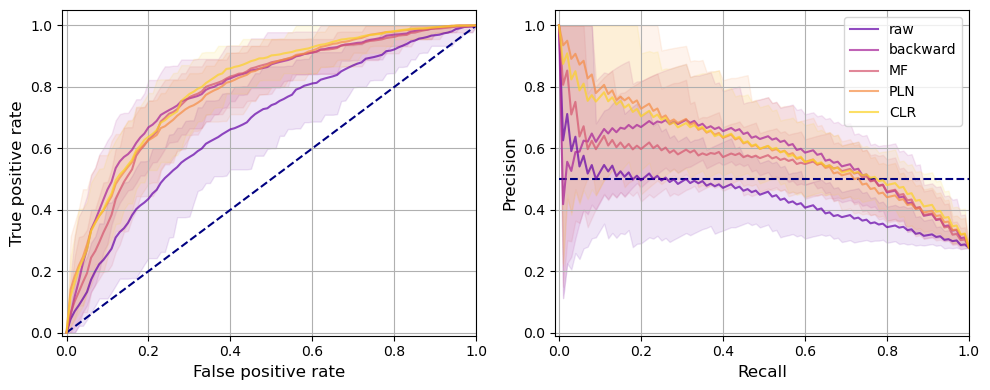

In [31]:
from sklearn.linear_model import LogisticRegression

benchmark_params = {'class_weight':'balanced'}
multiple_performances_summary(
    X_dic,
    y,
    LogisticRegression, benchmark_params,
    seed=seed,
    save_name=f'{prefix_labels}_ROC_logistic_regression'
)

### Random Forest

raw       backward             MF  \
accuracy            0.811 (0.019)  0.789 (0.018)  0.794 (0.021)   
precision           0.827 (0.026)   0.798 (0.03)  0.787 (0.028)   
recall              0.811 (0.019)  0.789 (0.018)  0.794 (0.021)   
F1                  0.781 (0.026)  0.751 (0.025)  0.771 (0.025)   
balanced accuracy   0.673 (0.032)   0.639 (0.03)  0.672 (0.031)   
ROC AUC             0.903 (0.022)  0.861 (0.026)  0.829 (0.028)   
PR AUC               0.79 (0.052)  0.727 (0.057)   0.66 (0.061)   
Averaged Precision   0.789 (0.05)  0.726 (0.055)  0.661 (0.059)   

                              PLN            CLR  
accuracy            0.773 (0.015)  0.784 (0.018)  
precision           0.786 (0.034)  0.791 (0.031)  
recall              0.773 (0.015)  0.784 (0.018)  
F1                  0.722 (0.022)  0.743 (0.027)  
balanced accuracy   0.604 (0.023)  0.629 (0.031)  
ROC AUC             0.887 (0.026)   0.864 (0.03)  
PR AUC              0.732 (0.068)  0.705 (0.061)  
Averaged Precision  0.732 (0.065)  0.705 (0.058)

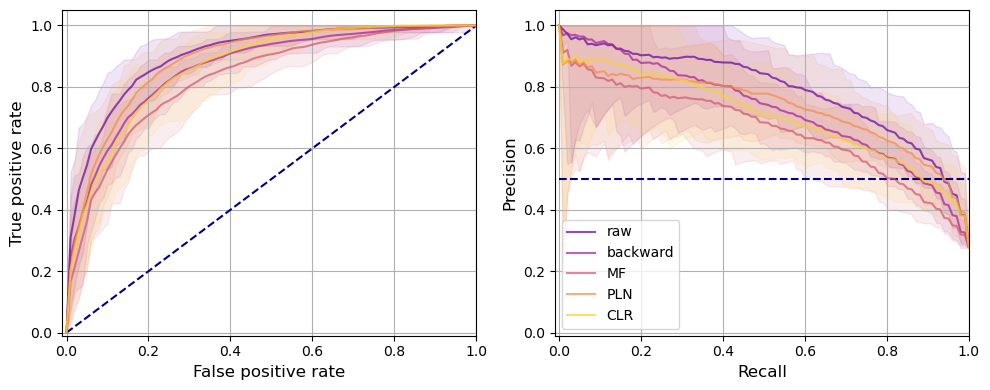

In [32]:
from sklearn.ensemble import RandomForestClassifier

benchmark_params = {
    'n_estimators':100,
    'class_weight':'balanced',
}
multiple_performances_summary(
    X_dic,
    y,
    RandomForestClassifier, benchmark_params,
    seed=seed,
    save_name=f'{prefix_labels}_ROC_randomforest'
)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

benchmark_params = {
    'n_estimators':100,
    'class_weight':'balanced'
}
X_dic_layers = {'Raw $\ell=6$': X}
for i in range(len(K)):
    X_dic_layers[f'PLN $\ell={i+selected_layers[0]}$'] = Z_pln_enc[:, i, :]
multiple_performances_summary(
    X_dic_layers,
    y,
    RandomForestClassifier, benchmark_params,
    seed=seed,
    save_name=f'{prefix_labels}_ROC_randomforest_PLN'
)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

benchmark_params = {
    'n_estimators':100,
    'class_weight':'balanced'
}
X_dic_layers = {'Raw $\ell=6$': X}
for i in range(len(K)):
    X_dic_layers[f'PLN-Tree (backward) $\ell={i+selected_layers[0]}$'] = backward.latent_tree_allocation(Z_backward).detach()[:, i, :]
multiple_performances_summary(
    X_dic_layers,
    y,
    RandomForestClassifier, benchmark_params,
    seed=seed,
    save_name=f'{prefix_labels}_ROC_randomforest_PLN-Tree_backward'
)

### SVM

raw       backward             MF  \
accuracy            0.584 (0.061)  0.747 (0.029)   0.737 (0.03)   
precision           0.673 (0.035)  0.781 (0.026)  0.777 (0.028)   
recall              0.584 (0.061)  0.747 (0.029)   0.737 (0.03)   
F1                  0.598 (0.062)  0.757 (0.027)  0.748 (0.029)   
balanced accuracy   0.586 (0.042)  0.738 (0.034)  0.732 (0.036)   
ROC AUC             0.545 (0.127)  0.797 (0.034)  0.782 (0.034)   
PR AUC              0.336 (0.085)   0.581 (0.07)  0.534 (0.058)   
Averaged Precision  0.347 (0.087)  0.593 (0.067)  0.545 (0.057)   

                              PLN            CLR  
accuracy             0.721 (0.03)  0.735 (0.034)  
precision           0.764 (0.025)  0.776 (0.027)  
recall               0.721 (0.03)  0.735 (0.034)  
F1                  0.732 (0.028)  0.746 (0.031)  
balanced accuracy   0.714 (0.033)   0.73 (0.035)  
ROC AUC              0.79 (0.036)  0.798 (0.036)  
PR AUC              0.596 (0.066)  0.587 (0.066)  
Averaged Precision  0.602 (0.064)  0.595 (0.063)

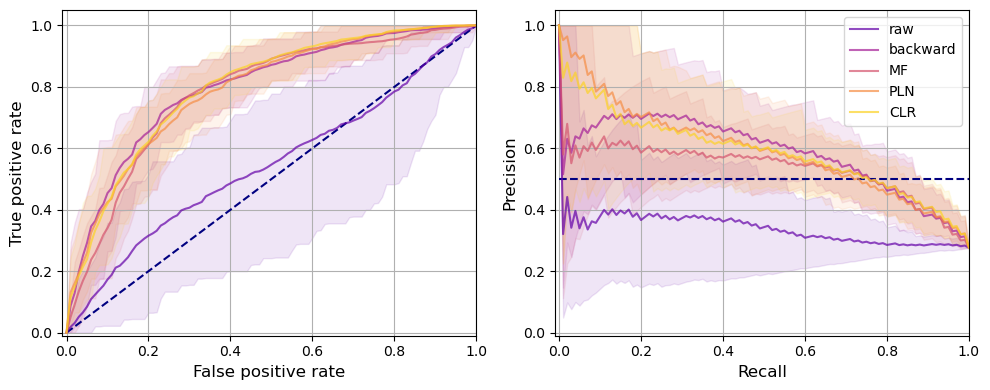

In [33]:
from sklearn.svm import SVC

benchmark_params = {
    'probability':True,
    'kernel':'linear',
    'C':0.1,
    'class_weight':'balanced'
}
multiple_performances_summary(
    X_dic,
    y,
    SVC, benchmark_params,
    seed=seed,
    save_name=f'{prefix_labels}_ROC_SVM'
)

### Neural network

raw       backward             MF  \
accuracy            0.777 (0.028)  0.813 (0.024)  0.778 (0.023)   
precision           0.773 (0.026)  0.809 (0.026)  0.774 (0.023)   
recall              0.777 (0.028)  0.813 (0.024)  0.778 (0.023)   
F1                  0.772 (0.027)  0.808 (0.025)  0.772 (0.023)   
balanced accuracy   0.704 (0.036)  0.746 (0.033)  0.704 (0.034)   
ROC AUC             0.782 (0.036)  0.844 (0.029)  0.784 (0.032)   
PR AUC               0.62 (0.062)   0.69 (0.057)  0.611 (0.049)   
Averaged Precision  0.627 (0.058)  0.697 (0.055)  0.617 (0.047)   

                              PLN            CLR  
accuracy              0.8 (0.026)  0.809 (0.026)  
precision           0.795 (0.028)  0.804 (0.027)  
recall                0.8 (0.026)  0.809 (0.026)  
F1                  0.795 (0.027)  0.804 (0.026)  
balanced accuracy   0.729 (0.036)   0.74 (0.035)  
ROC AUC             0.852 (0.029)   0.859 (0.03)  
PR AUC              0.677 (0.065)   0.717 (0.06)  
Averaged Precision  0.683 (0.062)  0.722 (0.058)

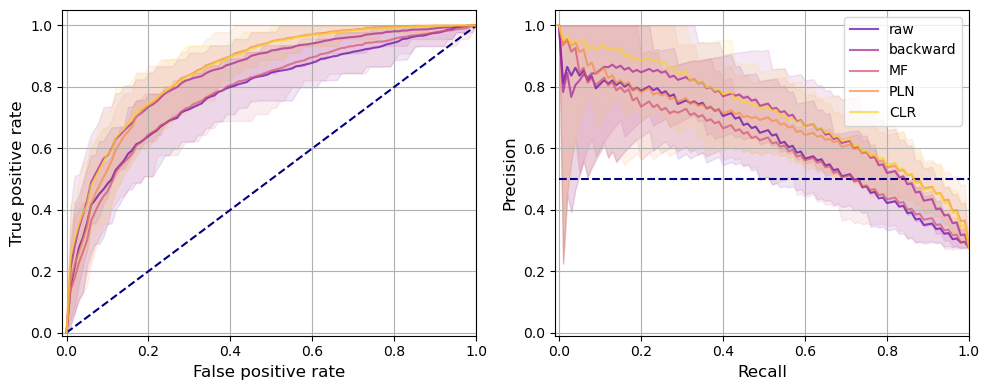

In [34]:
from sklearn.neural_network import MLPClassifier

benchmark_params = {
    'hidden_layer_sizes':(256, 256, 124),
}
multiple_performances_summary(
    X_dic,
    y,
    MLPClassifier, benchmark_params,
    seed=seed,
    save_name=f'{prefix_labels}_ROC_MLP'
)

## PLN-Tree Mixture Classifier

In [40]:
prefix = 'plntree_mixture_classifier-metagenomics-'

In [41]:
Y_base = metadata['disease']

scenario = 't2d'
prefix = prefix + scenario + '-'

if scenario == 'ibd':
    filtered_labels = ['ibd_crohn_disease', 'ibd_ulcerative_colitis']
elif scenario == 'cirrhosis':
    filtered_labels = ['cirrhosis']
elif scenario == 'obesity':
    filtered_labels = ['obesity']
elif scenario == 'colorectal':
    filtered_labels = ['cancer']
elif scenario == 'leaness':
    filtered_labels = ['leaness']
elif scenario == 't2d':
    filtered_labels = ['t2d']
elif scenario == 't2d_obe':
    filtered_labels = ['t2d', 'obesity']
elif scenario == 'cirr_col':
    filtered_labels = ['cirrhosis', 'colorectal']
prefix_labels = ''
for label in filtered_labels:
    prefix_labels += f'-{label}'
Y_base = metadata['disease'].copy()
for i in range(len(Y_base)):
    if Y_base[i] not in filtered_labels:
        Y_base[i] = 'Others'
    else:
        Y_base[i] = 'Targets'
Y_base[Y_base == 'Others'] = 0.
Y_base[Y_base == 'Targets'] = 1.
Y_base = Y_base.astype(np.float64)

In [42]:
n_classes = len(np.unique(Y_base))
n_classes

2

In [44]:
from plntree.data.utils import numpy_dataset_to_torch_dataloader
from sklearn.model_selection import StratifiedShuffleSplit

def train_test(X, y, train_indexes, test_indexes):
    X_train, y_train = X[train_indexes], y[train_indexes]
    X_test, y_test = X[test_indexes], y[test_indexes]
    return X_train, y_train, X_test, y_test

def torch_kfold(X, y, n_repeats=10, train_size=0.8, seed=None):
    seed_all(seed)
    dataloaders = []
    indexes = np.arange(0, len(X))
    for i, (train_indexes, test_indexes) in enumerate(StratifiedShuffleSplit(n_splits=n_repeats, train_size=train_size).split(X, y)):
        X_train, y_train, X_test, y_test = train_test(X, y, train_indexes, test_indexes)
        assert((np.unique(y_train) == np.unique(y_test)).all())
        dataloader = numpy_dataset_to_torch_dataloader(X_train, y_train, batch_size=532, shuffle=False)
        dataloaders.append((dataloader, X_test, y_test))
    return dataloaders

In [48]:
train_size = 0.4
n_repeat = 30
#prefix = prefix + f'{int(train_size * 100)}train'
dataloaders = torch_kfold(X_base, Y_base, n_repeats=n_repeat, train_size=train_size, seed=seed)

In [49]:
def learn_plntree_models(prefix, train_size, n_repeat=10):
    prefix_ = prefix + f'{int(train_size * 100)}train'
    dataloaders = torch_kfold(X_base, Y_base, n_repeats=n_repeat, train_size=train_size, seed=seed)
    preprocessing = 'proportion'
    def learn_plntree_classifier(dataloader, n_latent_layers, variational_approx, variational_approx_params):
        estimator = PLNTreeMixtureClassifier(
            tree=taxonomy,
            n_classes=n_classes,
            selected_layers=selected_layers,
            diag_smoothing_factor=1e-4,
            positive_fun='softplus',
            offset_method='constant',
            identifiable=True,
            variational_approx=variational_approx,
            variational_approx_params=variational_approx_params,
            n_latent_layers=n_latent_layers,
            seed=seed
        )
        optimizer = optim.Adam(
            estimator.parameters(),
            lr=1e-3,
        )
        estimator.to(dtype=torch.float64)
        n_epoch = 30_000
        return estimator.fit(optimizer, dataloader, n_epoch=n_epoch, verbose=100, max_grad_norm=5.)

    def embedder_params(embedder_type='GRU', embedding_size=16, n_embedding_layers=2, n_embedding_neurons=32, n_after_layers=2):
        params = {
            'embedder_type': embedder_type,
            'embedding_size': embedding_size,
            'n_embedding_layers': n_embedding_layers,
            'n_embedding_neurons': n_embedding_neurons,
            'n_after_layers': n_after_layers,
            'preprocessing': ['proportion']
        }
        name = f'Emb{embedder_type}-{n_embedding_layers}x{n_embedding_neurons}to{embedding_size}-{n_after_layers}'
        return name, params

    n_latent_layers = 1
    emb_name, variational_approx_params = embedder_params(
        embedding_size=32,
        n_embedding_layers=2,
        n_embedding_neurons=64,
        n_after_layers=2
    )
    plntree_loaders = []
    for fold, (dataloader, X_test, y_test) in enumerate(dataloaders):
        try:
            backward, backward_losses = load_pkl(prefix_, f'residual_backward_{preprocessing}_{n_latent_layers}-{emb_name}-fold{fold}')
        except:
            print('Learning PLN-Tree (residual backward)')
            print(variational_approx_params)
            backward, backward_losses = learn_plntree_classifier(dataloader, n_latent_layers, 'residual_backward', variational_approx_params)
            save_pkl((backward, backward_losses), prefix_, f'residual_backward_{preprocessing}_{n_latent_layers}-{emb_name}-fold{fold}')
        X_train = torch.concatenate([X_ for (X_, Y_) in dataloader])
        y_train = torch.concatenate([Y_ for (X_, Y_) in dataloader])[:, 1]
        plntree_loaders.append((backward, X_train, y_train, X_test, y_test))
    return plntree_loaders
plntree_loaders_list = {}
train_size_list = [0.4, 0.6, 0.8]
for train_size in train_size_list:
    plntree_loaders = learn_plntree_models(prefix, train_size=train_size, n_repeat=n_repeat)
    plntree_loaders_list[train_size] = plntree_loaders

Loading file ./experiments/saves/plntree_mixture_classifier-metagenomics-t2d-40train_residual_backward_proportion_1-EmbGRU-2x64to32-2-fold0.pkl
Loading file ./experiments/saves/plntree_mixture_classifier-metagenomics-t2d-40train_residual_backward_proportion_1-EmbGRU-2x64to32-2-fold1.pkl
Loading file ./experiments/saves/plntree_mixture_classifier-metagenomics-t2d-40train_residual_backward_proportion_1-EmbGRU-2x64to32-2-fold2.pkl
Loading file ./experiments/saves/plntree_mixture_classifier-metagenomics-t2d-40train_residual_backward_proportion_1-EmbGRU-2x64to32-2-fold3.pkl
Loading file ./experiments/saves/plntree_mixture_classifier-metagenomics-t2d-40train_residual_backward_proportion_1-EmbGRU-2x64to32-2-fold4.pkl
Loading file ./experiments/saves/plntree_mixture_classifier-metagenomics-t2d-40train_residual_backward_proportion_1-EmbGRU-2x64to32-2-fold5.pkl
Loading file ./experiments/saves/plntree_mixture_classifier-metagenomics-t2d-40train_residual_backward_proportion_1-EmbGRU-2x64to32-2-fo

[*] Epoch: 9300 Average loss: 1514.0511    | Remaining Time: 01:32:05
[*] Epoch: 9400 Average loss: 1598.5157    | Remaining Time: 01:31:22
[*] Epoch: 9500 Average loss: 1567.1671    | Remaining Time: 01:27:14
[*] Epoch: 9600 Average loss: 1694.8113    | Remaining Time: 01:27:21
[*] Epoch: 9700 Average loss: 2695.3042    | Remaining Time: 01:27:58
[*] Epoch: 9800 Average loss: 1685.0542    | Remaining Time: 01:28:04
[*] Epoch: 9900 Average loss: 1564.0426    | Remaining Time: 01:30:36
[*] Epoch: 10000 Average loss: 1603.1139    | Remaining Time: 01:20:35
[*] Epoch: 10100 Average loss: 1564.5171    | Remaining Time: 01:23:42
[*] Epoch: 10200 Average loss: 1523.7146    | Remaining Time: 02:22:14
[*] Epoch: 10300 Average loss: 1555.1644    | Remaining Time: 01:28:08
[*] Epoch: 10400 Average loss: 1524.2812    | Remaining Time: 01:26:01
[*] Epoch: 10500 Average loss: 1538.8474    | Remaining Time: 01:23:38
[*] Epoch: 10600 Average loss: 1372.6704    | Remaining Time: 01:17:58
[*] Epoch: 10

KeyboardInterrupt: 

In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, balanced_accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc, average_precision_score, RocCurveDisplay
import pandas as pd
import numpy as np
from scipy import interp
from scipy.stats import mstats
import math

def performances(benchmarks, predict_args=None):
    if predict_args is None:
        predict_args = {}
    metrics = {
        'accuracy':accuracy_score,
        'precision':lambda y_test, y_pred: precision_score(y_test, y_pred, average='weighted'),
        'recall':lambda y_test, y_pred: recall_score(y_test, y_pred, average='weighted'),
        'F1':lambda y_test, y_pred: f1_score(y_test, y_pred, average='weighted'),
        'balanced accuracy':balanced_accuracy_score,
    }
    results = {f'{key}':[] for key in metrics}
    conf_matrices = []
    auc_args = []
    pr_args = []
    auc_values = []
    auc_pr_values = []
    pr_values = []
    for model, X_test, y_test in benchmarks:
        y_proba = model.predict_proba(X_test, **predict_args)
        if len(predict_args) == 0:
            y_pred = model.predict(X_test)
        else:
            y_pred = model.predict(X_test, **predict_args)
        for metric, metric_fun in metrics.items():
            results[metric].append(metric_fun(y_test, y_pred))
            
        conf_matrices.append(confusion_matrix(y_test, y_pred))
        
        if len(np.unique(y_test)) == 2:
            fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1])
            base_fpr = np.linspace(0, 1, 101)
            tpr_interp = interp(base_fpr, fpr, tpr)
            tpr_interp[0] = 0.0
            auc_args.append(tpr_interp)
            auc_values.append(auc(fpr, tpr))
            
            precisions, recalls, pr_thresh = precision_recall_curve(y_test, y_proba[:, 1])
            base_recalls = np.linspace(0, 1, 101)
            pre_interp = interp(base_recalls, np.flip(recalls), np.flip(precisions))
            pre_interp[0] = np.flip(precisions)[0]
            pr_args.append(pre_interp)
            auc_pr_values.append(auc(recalls, precisions))
            pr_values.append(average_precision_score(y_test, y_proba[:, 1]))
    if len(auc_values) > 0:
        results['ROC AUC'] = auc_values
    if len(pr_values) > 0:
        results['PR AUC'] = auc_pr_values
        results['Averaged Precision'] = pr_values
    return results, conf_matrices, auc_args, pr_args

import matplotlib
import seaborn as sns
def augment(X, y, label, augment_size, backward):
    X_add, y_add, Z_add, O_add = backward.conditional_sample(augment_size, int(label))
    y_add = y_add[:len(X_add)]
    X_augment = torch.concatenate([X, X_add])
    y_augment = torch.concatenate([y, y_add[:, 1]])
    assert(len(X_augment) == len(y_augment))
    return X_augment, y_augment

def augment_all(X, y, augment_size, backward):
    X_augment, y_augment = X.clone(), y.clone()
    for label in np.unique(y):
        X_augment, y_augment = augment(X_augment, y_augment, label, augment_size, backward)
    return X_augment, y_augment

def benchmarks_data_builder(plntree_loaders):
    builder = {}
    def add_build(name, entry):
        if name not in builder:
            builder[name] = []
        builder[name].append(list(entry))
    for fold, (backward, X_train, y_train, X_test, y_test) in enumerate(plntree_loaders):
        add_build('raw', (X_train, y_train, X_test, y_test))
        add_build('+100', (*augment_all(X_train, y_train, 50, backward), X_test, y_test))
        add_build('+300', (*augment_all(X_train, y_train, 150, backward), X_test, y_test))
        add_build('+600', (*augment_all(X_train, y_train, 300, backward), X_test, y_test))
        add_build('+800', (*augment_all(X_train, y_train, 400, backward), X_test, y_test))
        add_build('+1000', (*augment_all(X_train, y_train, 500, backward), X_test, y_test))
        add_build('+1500', (*augment_all(X_train, y_train, 750, backward), X_test, y_test))
        add_build('+2000', (*augment_all(X_train, y_train, 1000, backward), X_test, y_test))
    return builder

def fit_models(model, params, datasets):
    results = []
    for X_train, y_train, X_test, y_test in datasets:
        # Normalization preprocessing before fitting/testing
        X_prop_train = X_train[:, -1, :] / X_train[:, -1, :].sum(dim=-1, keepdims=True)
        X_prop_test = X_test[:, -1, :] / X_test[:, -1, :].sum(dim=-1, keepdims=True)
        benchmark = model(**params).fit(X_prop_train, y_train)
        results.append((benchmark, X_prop_test, y_test))
    return results

np.set_printoptions(suppress=True)
def multiple_performances_summary(plntree_loaders, model, params, percentile=0.05, save_name=None, seed=None, display=[], verbose=False):
    df = None
    seed_all(seed)
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].plot([0, 1], [0, 1], color="navy", linestyle="--")
    axs[1].plot([0, 1], [0.5, 0.5], color="navy", linestyle="--")
    benchmarks_data = benchmarks_data_builder(plntree_loaders)
    colors = [matplotlib.cm.get_cmap('plasma')(1e-8 + (i+1)/(len(benchmarks_data)+.5)) for i in range(len(benchmarks_data))]
    displays = {}
    for entry in display:
        displays[entry] = pd.DataFrame()
    for k, (name, dataset) in enumerate(benchmarks_data.items()):
        benchmarks = fit_models(model, params, dataset)
        results, conf_matrices, auc_args, pre_args = performances(benchmarks)
        for entry in display:
            if entry in results:
                displays[entry][name] = results[entry]
        inputs = []
        metrics = []
        for metric, res in results.items():
            inputs.append(f'{np.round(np.mean(res), decimals=3)} ({np.round(np.std(res), decimals=3)})')
            metrics.append(metric)
        if df is None:
            df = pd.DataFrame(columns=metrics)
        df.loc[name] = inputs
        if len(auc_args) > 0:
            base_fpr = np.linspace(0, 1, 101)
            axs[0].set_xlim([-0.01, 1.0])
            axs[0].set_ylim([-0.01, 1.05])
            axs[0].set_ylabel('True positive rate', fontsize=12)
            axs[0].set_xlabel('False positive rate', fontsize=12)

            roc_tpr_array = np.array(auc_args)
            for i in range(len(roc_tpr_array)):
                for j in range(roc_tpr_array.shape[1]):
                    if math.isnan(roc_tpr_array[i][j]):
                        roc_tpr_array[i][j] = 0
            mean_tprs = roc_tpr_array.mean(axis=0)
            std_tprs = roc_tpr_array.std(axis=0)
            axs[0].plot(base_fpr, mean_tprs, color=colors[k], label=name, alpha=0.7)

            quantiles = mstats.mquantiles(roc_tpr_array, prob=[percentile, 1-percentile], axis=0)
            axs[0].fill_between(base_fpr, quantiles[0], quantiles[1], color=colors[k], alpha=0.1)
        if len(pre_args) > 0:
            base_recalls = np.linspace(0, 1, 101)
            axs[1].set_xlim([-0.01, 1.0])
            axs[1].set_ylim([-0.01, 1.05])
            axs[1].set_ylabel('Precision', fontsize=12)
            axs[1].set_xlabel('Recall', fontsize=12)

            precisions = np.array(pre_args)
            for i in range(len(precisions)):
                for j in range(precisions.shape[1]):
                    if math.isnan(precisions[i][j]):
                        precisions[i][j] = 0.
            mean_precisions = precisions.mean(axis=0)
            std_precisions = precisions.std(axis=0)
            axs[1].plot(base_recalls, mean_precisions, color=colors[k], label=name, alpha=0.7)

            quantiles = mstats.mquantiles(precisions, prob=[percentile, 1-percentile], axis=0)
            axs[1].fill_between(base_recalls, quantiles[0], quantiles[1], color=colors[k], alpha=0.1)
    #axs[0].legend()
    axs[0].grid('True')
    axs[1].legend()
    axs[1].grid('True')
    plt.tight_layout()
    if save_name is not None:
        savefig(f'{prefix}_{save_name}')
    for name, display_df in displays.items():
        f, a = plt.subplots(figsize=(12, 3))
        a.grid(True, zorder=3, alpha=0.5)
        a.set_title(name)
        sns.boxplot(data=display_df, ax=a, palette='viridis', fliersize=0.)
        sns.stripplot(data=display_df, ax=a, palette='viridis', alpha=0.5)
        #sns.pointplot(data=display_df, ax=a, color='black', ci=0, markers='.', linestyles='--')
    return df.transpose()

### Augmentation with 80% of the dataset

In [25]:
# Showcasing the performances when using 80% of the dataset for training
plntree_loaders = plntree_loaders_list[0.4]

Generated batch size: 399


raw           +100           +300  \
accuracy            0.622 (0.035)  0.619 (0.037)  0.627 (0.038)   
precision           0.691 (0.024)  0.693 (0.029)  0.688 (0.021)   
recall              0.622 (0.035)  0.619 (0.037)  0.627 (0.038)   
F1                  0.639 (0.033)  0.638 (0.034)  0.644 (0.034)   
balanced accuracy   0.615 (0.031)  0.618 (0.037)  0.613 (0.028)   
ROC AUC              0.656 (0.03)  0.657 (0.034)  0.654 (0.034)   
PR AUC               0.414 (0.03)  0.412 (0.027)  0.407 (0.021)   
Averaged Precision   0.419 (0.03)  0.418 (0.027)  0.413 (0.021)   

                             +600           +800          +1000  \
accuracy             0.65 (0.026)   0.65 (0.043)  0.662 (0.041)   
precision           0.696 (0.013)  0.695 (0.018)  0.703 (0.025)   
recall               0.65 (0.026)   0.65 (0.043)  0.662 (0.041)   
F1                  0.664 (0.023)  0.664 (0.038)  0.675 (0.037)   
balanced accuracy   0.623 (0.018)  0.622 (0.025)  0.633 (0.033)   
ROC AUC             0.659 (0.017)  0.663 (0.026)  0.669 (0.031)   
PR AUC              0.413 (0.021)  0.418 (0.018)  0.423 (0.017)   
Averaged Precision  0.419 (0.021)  0.424 (0.018)  0.429 (0.017)   

                            +1500          +2000  
accuracy            0.655 (0.032)  0.667 (0.035)  
precision             0.7 (0.019)  0.707 (0.024)  
recall              0.655 (0.032)  0.667 (0.035)  
F1                  0.669 (0.028)   0.68 (0.031)  
balanced accuracy   0.629 (0.026)  0.638 (0.032)  
ROC AUC             0.672 (0.027)  0.677 (0.025)  
PR AUC              0.424 (0.017)  0.426 (0.018)  
Averaged Precision  0.429 (0.017)  0.431 (0.018)

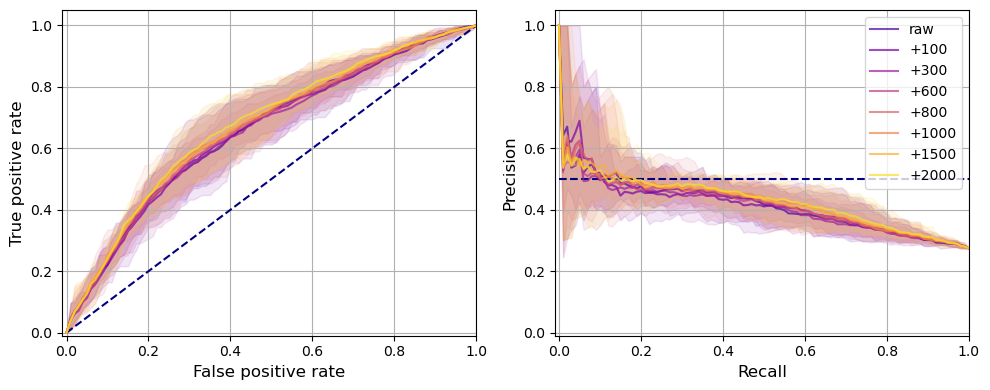

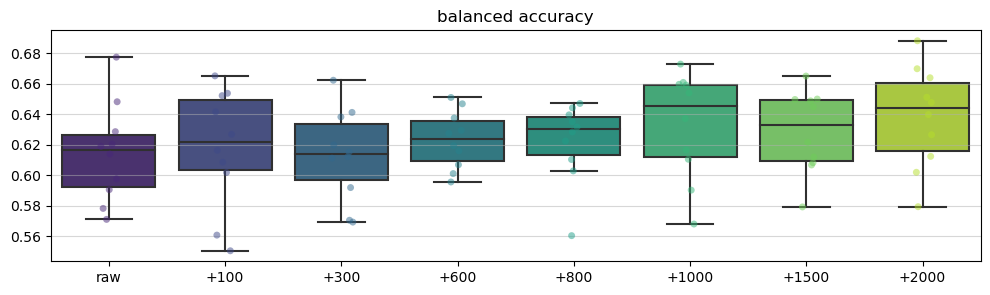

In [26]:
from sklearn.linear_model import LogisticRegression

benchmark_params = {'class_weight':'balanced'}
multiple_performances_summary(
    plntree_loaders, 
    LogisticRegression, benchmark_params, 
    percentile=0.05, 
    save_name=None,
    display=['balanced accuracy', 'ROC AUC'],
    seed=seed, 
)

Generated batch size: 399


raw           +100           +300  \
accuracy            0.293 (0.026)  0.356 (0.126)  0.612 (0.098)   
precision           0.377 (0.307)  0.485 (0.269)  0.668 (0.023)   
recall              0.293 (0.026)  0.356 (0.126)  0.612 (0.098)   
F1                  0.164 (0.067)  0.257 (0.194)  0.609 (0.107)   
balanced accuracy    0.503 (0.01)  0.518 (0.027)   0.579 (0.04)   
ROC AUC             0.371 (0.038)  0.389 (0.086)  0.623 (0.031)   
PR AUC              0.221 (0.014)   0.235 (0.05)  0.373 (0.024)   
Averaged Precision  0.224 (0.014)  0.238 (0.051)  0.379 (0.025)   

                             +600           +800          +1000  \
accuracy            0.585 (0.106)  0.632 (0.099)  0.619 (0.084)   
precision           0.673 (0.014)  0.681 (0.018)  0.683 (0.017)   
recall              0.585 (0.106)  0.632 (0.099)  0.619 (0.084)   
F1                  0.584 (0.114)  0.629 (0.111)  0.622 (0.091)   
balanced accuracy    0.579 (0.03)  0.595 (0.036)  0.598 (0.035)   
ROC AUC              0.633 (0.03)  0.631 (0.029)  0.636 (0.033)   
PR AUC              0.383 (0.025)  0.382 (0.026)  0.384 (0.021)   
Averaged Precision   0.39 (0.025)  0.387 (0.026)  0.389 (0.021)   

                            +1500          +2000  
accuracy             0.608 (0.08)  0.635 (0.057)  
precision           0.686 (0.014)  0.692 (0.019)  
recall               0.608 (0.08)  0.635 (0.057)  
F1                  0.615 (0.077)  0.649 (0.052)  
balanced accuracy   0.598 (0.025)  0.615 (0.025)  
ROC AUC              0.64 (0.027)  0.644 (0.026)  
PR AUC              0.387 (0.022)  0.387 (0.021)  
Averaged Precision  0.392 (0.022)  0.392 (0.021)

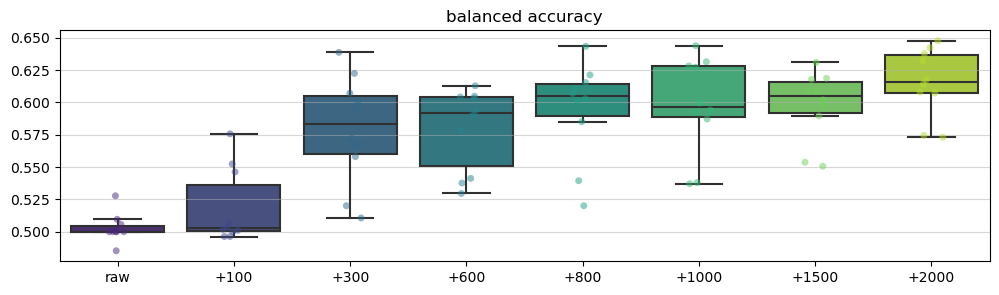

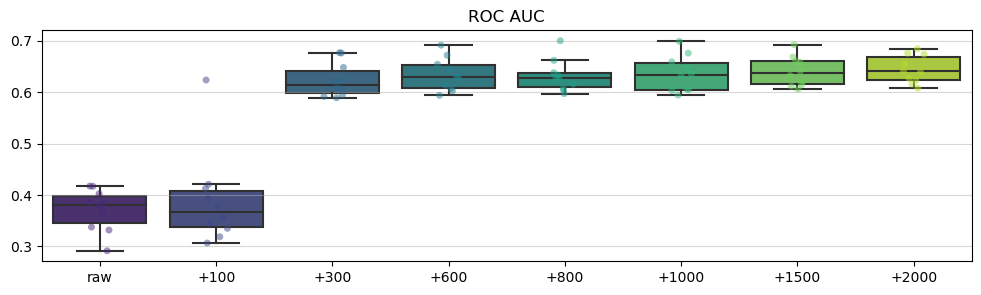

In [27]:
from sklearn.svm import SVC

benchmark_params = {
    'probability':True,
    'kernel':'linear',
    'C':0.1,
    'class_weight':'balanced'
}
multiple_performances_summary(
    plntree_loaders, 
    SVC, benchmark_params, 
    percentile=0.05, 
    save_name=None, 
    display=['balanced accuracy', 'ROC AUC'],
    seed=seed, 
)

Generated batch size: 399


raw           +100           +300  \
accuracy            0.787 (0.012)  0.805 (0.011)  0.809 (0.009)   
precision            0.801 (0.02)  0.808 (0.016)   0.81 (0.013)   
recall              0.787 (0.012)  0.805 (0.011)  0.809 (0.009)   
F1                  0.743 (0.018)  0.777 (0.014)  0.785 (0.013)   
balanced accuracy    0.625 (0.02)  0.669 (0.017)   0.682 (0.02)   
ROC AUC             0.893 (0.015)  0.887 (0.012)  0.875 (0.015)   
PR AUC                0.75 (0.04)  0.735 (0.034)  0.714 (0.031)   
Averaged Precision   0.752 (0.04)  0.737 (0.033)   0.716 (0.03)   

                             +600           +800          +1000  \
accuracy             0.806 (0.01)  0.808 (0.012)   0.803 (0.01)   
precision           0.803 (0.015)    0.8 (0.013)  0.797 (0.012)   
recall               0.806 (0.01)  0.808 (0.012)   0.803 (0.01)   
F1                  0.783 (0.014)  0.792 (0.012)  0.784 (0.012)   
balanced accuracy    0.683 (0.02)  0.703 (0.017)   0.689 (0.02)   
ROC AUC             0.864 (0.019)  0.863 (0.017)  0.856 (0.018)   
PR AUC              0.699 (0.031)  0.692 (0.028)  0.684 (0.032)   
Averaged Precision   0.701 (0.03)  0.694 (0.027)  0.686 (0.032)   

                            +1500          +2000  
accuracy            0.799 (0.016)  0.798 (0.016)  
precision           0.791 (0.015)   0.79 (0.016)  
recall              0.799 (0.016)  0.798 (0.016)  
F1                  0.789 (0.016)  0.789 (0.016)  
balanced accuracy    0.71 (0.024)   0.71 (0.022)  
ROC AUC             0.847 (0.019)  0.843 (0.018)  
PR AUC              0.673 (0.029)   0.66 (0.031)  
Averaged Precision  0.675 (0.028)   0.662 (0.03)

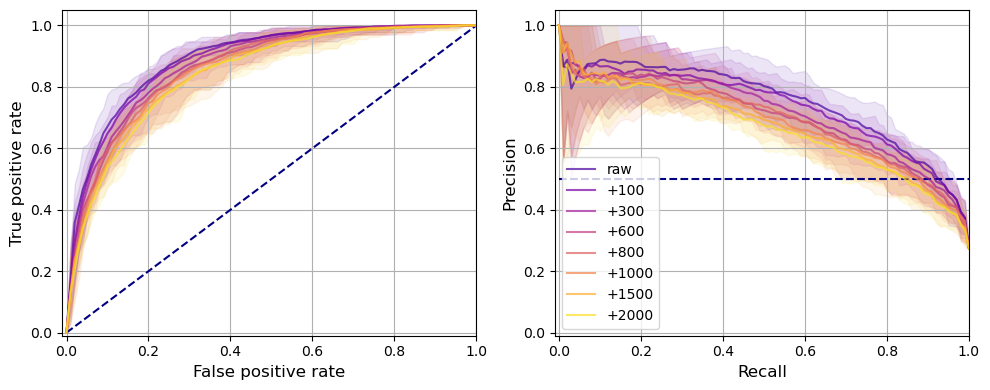

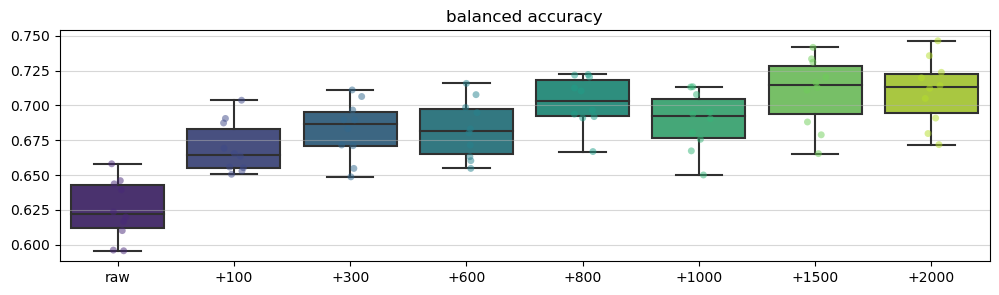

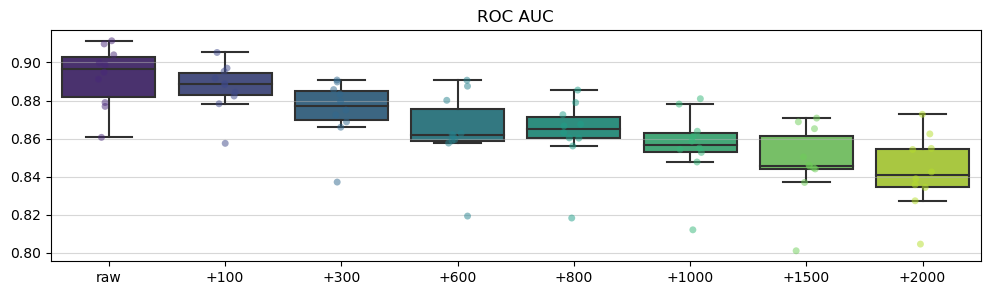

In [28]:
from sklearn.ensemble import RandomForestClassifier
benchmark_params = {
    'n_estimators':1000,
    'class_weight':'balanced'
}
multiple_performances_summary(
    plntree_loaders, 
    RandomForestClassifier, benchmark_params, 
    percentile=0.05, 
    save_name=None, 
    display=['balanced accuracy', 'ROC AUC'],
    seed=seed, 
)

In [37]:
from sklearn.neural_network import MLPClassifier

benchmark_params = {
    'hidden_layer_sizes':(256, 256, 124),
}
multiple_performances_summary(
    plntree_loaders, 
    MLPClassifier, benchmark_params, 
    percentile=0.05, 
    save_name=None, 
    display=['balanced accuracy', 'ROC AUC'],
    seed=seed, 
)

Generated batch size: 299
Generated batch size: 499
Generated batch size: 749
Generated batch size: 498


raw           +100           +300  \
accuracy            0.785 (0.025)  0.766 (0.028)  0.772 (0.034)   
precision            0.782 (0.02)  0.769 (0.022)  0.775 (0.031)   
recall              0.785 (0.025)  0.766 (0.028)  0.772 (0.034)   
F1                  0.779 (0.022)  0.767 (0.025)  0.772 (0.031)   
balanced accuracy   0.712 (0.024)   0.71 (0.027)  0.715 (0.032)   
ROC AUC             0.797 (0.025)  0.784 (0.033)  0.789 (0.035)   
PR AUC              0.631 (0.056)  0.619 (0.057)  0.623 (0.055)   
Averaged Precision  0.638 (0.053)  0.626 (0.054)  0.629 (0.053)   

                             +600           +800          +1000  \
accuracy            0.779 (0.022)  0.774 (0.025)  0.782 (0.014)   
precision           0.786 (0.023)  0.784 (0.017)  0.782 (0.018)   
recall              0.779 (0.022)  0.774 (0.025)  0.782 (0.014)   
F1                  0.778 (0.019)   0.776 (0.02)   0.78 (0.015)   
balanced accuracy   0.727 (0.032)   0.73 (0.023)  0.723 (0.031)   
ROC AUC             0.802 (0.028)  0.797 (0.027)  0.796 (0.029)   
PR AUC              0.634 (0.053)  0.636 (0.049)  0.609 (0.047)   
Averaged Precision   0.641 (0.05)  0.644 (0.046)  0.618 (0.046)   

                            +1500          +2000  
accuracy            0.774 (0.026)   0.777 (0.03)  
precision           0.776 (0.025)  0.783 (0.029)  
recall              0.774 (0.026)   0.777 (0.03)  
F1                  0.773 (0.026)  0.776 (0.029)  
balanced accuracy   0.716 (0.037)  0.725 (0.044)  
ROC AUC             0.791 (0.037)  0.795 (0.033)  
PR AUC                0.63 (0.06)  0.614 (0.066)  
Averaged Precision  0.637 (0.058)  0.623 (0.063)

### Augmentation with varying percentage of training size

In [118]:
def benchmark_add_builder(plntree_loaders, augment):
    builder = {}
    builder[f'+{augment}'] = []
    for fold, (backward, X_train, y_train, X_test, y_test) in enumerate(plntree_loaders):
        builder[f'+{augment}'].append((*augment_all(X_train, y_train, augment, backward), X_test, y_test))
    return builder

def compare_plntree_loaders(plntree_loaders_dic, model, params, augment=800, percentile=0.05, save_name=None, seed=None, display=[]):
    df = None
    seed_all(seed)
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].plot([0, 1], [0, 1], color="navy", linestyle="--")
    axs[1].plot([0, 1], [0.5, 0.5], color="navy", linestyle="--")
    benchmarks_data = {}
    for train_size, plntree_loaders in plntree_loaders_dic.items():
        benchmarks_data[f'raw {int(train_size*100)}%'] = []
        for fold, (backward, X_train, y_train, X_test, y_test) in enumerate(plntree_loaders):
            benchmarks_data[f'raw {int(train_size*100)}%'].append((X_train, y_train, X_test, y_test))
    for train_size, plntree_loaders in plntree_loaders_dic.items():
        benchmarks_data[f'+{augment} - {int(train_size*100)}% - {int(train_size * len(Y_base))}'] = benchmark_add_builder(plntree_loaders, augment)[f'+{augment}']
    colors = [matplotlib.cm.get_cmap('plasma')(1e-8 + (i+1)/(len(benchmarks_data)+.5)) for i in range(len(benchmarks_data))]
    displays = {}
    for entry in display:
        displays[entry] = pd.DataFrame()
    for k, (name, dataset) in enumerate(benchmarks_data.items()):
        benchmarks = fit_models(model, params, dataset)
        results, conf_matrices, auc_args, pre_args = performances(benchmarks)
        for entry in display:
            if entry in results:
                displays[entry][name] = results[entry]
        inputs = []
        metrics = []
        for metric, res in results.items():
            inputs.append(f'{np.round(np.mean(res), decimals=3)} ({np.round(np.std(res), decimals=3)})')
            metrics.append(metric)
        if df is None:
            df = pd.DataFrame(columns=metrics)
        df.loc[name] = inputs
        if len(auc_args) > 0:
            base_fpr = np.linspace(0, 1, 101)
            axs[0].set_xlim([-0.01, 1.0])
            axs[0].set_ylim([-0.01, 1.05])
            axs[0].set_ylabel('True positive rate', fontsize=12)
            axs[0].set_xlabel('False positive rate', fontsize=12)

            roc_tpr_array = np.array(auc_args)
            for i in range(len(roc_tpr_array)):
                for j in range(roc_tpr_array.shape[1]):
                    if math.isnan(roc_tpr_array[i][j]):
                        roc_tpr_array[i][j] = 0
            mean_tprs = roc_tpr_array.mean(axis=0)
            std_tprs = roc_tpr_array.std(axis=0)
            axs[0].plot(base_fpr, mean_tprs, color=colors[k], label=name, alpha=0.7)

            quantiles = mstats.mquantiles(roc_tpr_array, prob=[percentile, 1-percentile], axis=0)
            axs[0].fill_between(base_fpr, quantiles[0], quantiles[1], color=colors[k], alpha=0.1)
        if len(pre_args) > 0:
            base_recalls = np.linspace(0, 1, 101)
            axs[1].set_xlim([-0.01, 1.0])
            axs[1].set_ylim([-0.01, 1.05])
            axs[1].set_ylabel('Precision', fontsize=12)
            axs[1].set_xlabel('Recall', fontsize=12)

            precisions = np.array(pre_args)
            for i in range(len(precisions)):
                for j in range(precisions.shape[1]):
                    if math.isnan(precisions[i][j]):
                        precisions[i][j] = 0.
            mean_precisions = precisions.mean(axis=0)
            std_precisions = precisions.std(axis=0)
            axs[1].plot(base_recalls, mean_precisions, color=colors[k], label=name, alpha=0.7)

            quantiles = mstats.mquantiles(precisions, prob=[percentile, 1-percentile], axis=0)
            axs[1].fill_between(base_recalls, quantiles[0], quantiles[1], color=colors[k], alpha=0.1)
    #axs[0].legend()
    axs[0].grid('True')
    axs[1].legend()
    axs[1].grid('True')
    plt.tight_layout()
    if save_name is not None:
        savefig(f'{prefix}_{save_name}')
    for name, display_df in displays.items():
        f, a = plt.subplots(figsize=(12, 3))
        a.grid(True, zorder=3, alpha=0.5)
        a.set_title(name)
        sns.boxplot(data=display_df, ax=a, palette='viridis', fliersize=0.)
        sns.stripplot(data=display_df, ax=a, palette='viridis', alpha=0.5)
        #sns.pointplot(data=display_df, ax=a, color='black', ci=0, markers='.', linestyles='--')
    return df.transpose()

Generated batch size: 799


raw 40%        raw 60%        raw 80%  \
accuracy            0.622 (0.035)  0.651 (0.034)   0.642 (0.05)   
precision           0.691 (0.024)  0.704 (0.023)  0.701 (0.039)   
recall              0.622 (0.035)  0.651 (0.034)   0.642 (0.05)   
F1                  0.639 (0.033)  0.666 (0.031)  0.659 (0.046)   
balanced accuracy   0.615 (0.031)   0.633 (0.03)  0.631 (0.051)   
ROC AUC              0.656 (0.03)   0.666 (0.03)  0.682 (0.053)   
PR AUC               0.414 (0.03)   0.423 (0.04)  0.442 (0.071)   
Averaged Precision   0.419 (0.03)  0.429 (0.039)  0.454 (0.069)   

                   +800 - 40% - 326 +800 - 60% - 489 +800 - 80% - 652  
accuracy              0.671 (0.034)     0.66 (0.029)    0.661 (0.053)  
precision              0.709 (0.02)      0.7 (0.022)    0.703 (0.045)  
recall                0.671 (0.034)     0.66 (0.029)    0.661 (0.053)  
F1                     0.683 (0.03)    0.672 (0.025)    0.672 (0.049)  
balanced accuracy     0.641 (0.027)     0.628 (0.03)    0.633 (0.059)  
ROC AUC               0.674 (0.025)    0.677 (0.026)      0.69 (0.06)  
PR AUC                0.428 (0.018)    0.426 (0.033)    0.462 (0.086)  
Averaged Precision    0.433 (0.018)    0.433 (0.031)    0.472 (0.085)

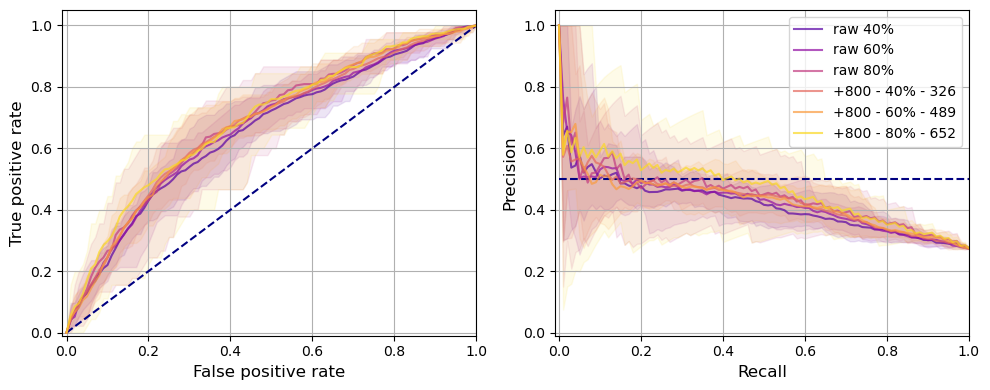

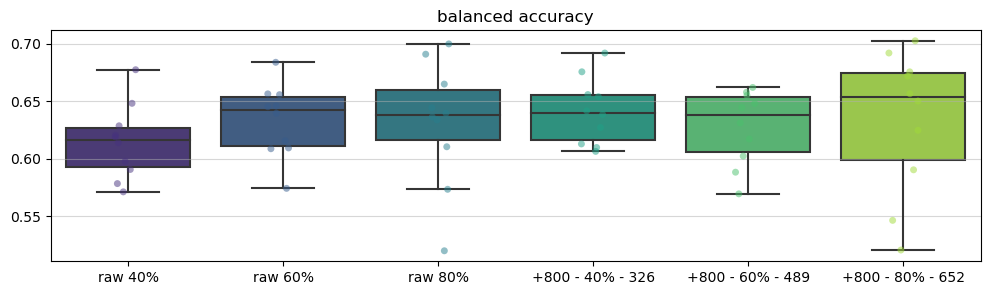

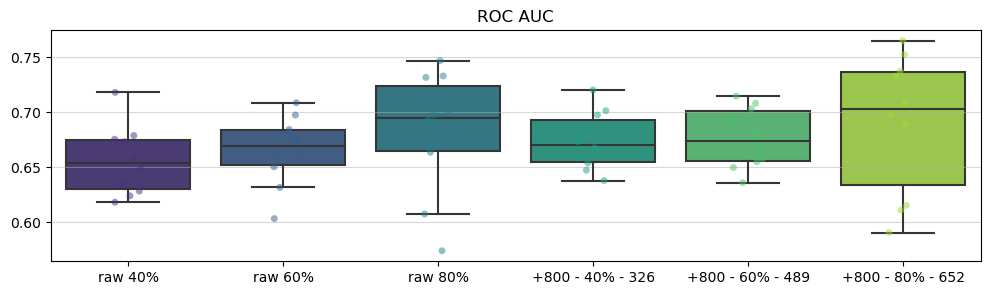

In [119]:
from sklearn.linear_model import LogisticRegression

benchmark_params = {'class_weight':'balanced'}
compare_plntree_loaders(
    plntree_loaders_list, 
    LogisticRegression, benchmark_params, 
    percentile=0.05, 
    save_name=None,
    display=['balanced accuracy', 'ROC AUC'],
    seed=seed, 
)

Generated batch size: 799


raw 40%        raw 60%        raw 80%  \
accuracy            0.293 (0.026)  0.398 (0.102)  0.584 (0.074)   
precision           0.377 (0.307)  0.704 (0.048)  0.679 (0.039)   
recall              0.293 (0.026)  0.398 (0.102)  0.584 (0.074)   
F1                  0.164 (0.067)  0.342 (0.151)  0.594 (0.083)   
balanced accuracy    0.503 (0.01)  0.537 (0.013)  0.589 (0.044)   
ROC AUC             0.371 (0.038)  0.459 (0.121)   0.485 (0.14)   
PR AUC              0.221 (0.014)  0.273 (0.074)  0.295 (0.085)   
Averaged Precision  0.224 (0.014)  0.279 (0.076)  0.306 (0.087)   

                   +800 - 40% - 326 +800 - 60% - 489 +800 - 80% - 652  
accuracy              0.622 (0.074)    0.645 (0.074)      0.629 (0.1)  
precision             0.687 (0.019)    0.691 (0.018)    0.692 (0.027)  
recall                0.622 (0.074)    0.645 (0.074)      0.629 (0.1)  
F1                     0.63 (0.069)    0.646 (0.069)    0.627 (0.115)  
balanced accuracy     0.603 (0.031)    0.604 (0.039)    0.607 (0.049)  
ROC AUC               0.645 (0.028)    0.643 (0.029)    0.652 (0.059)  
PR AUC                0.389 (0.021)    0.389 (0.038)     0.412 (0.07)  
Averaged Precision    0.394 (0.021)    0.397 (0.038)    0.424 (0.068)

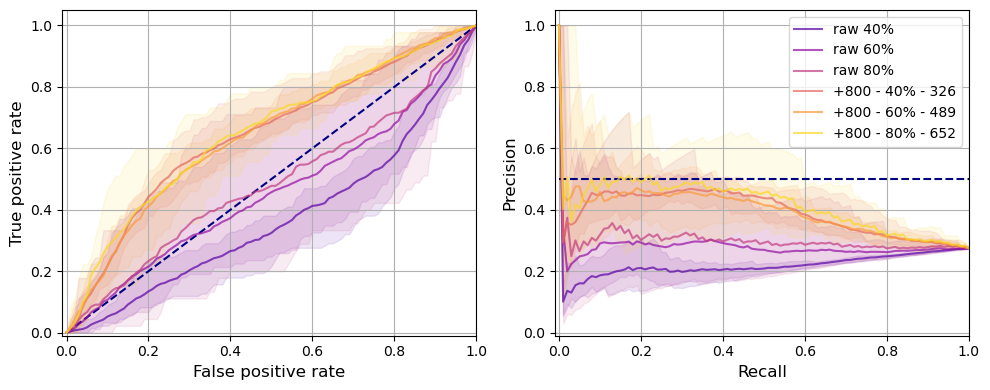

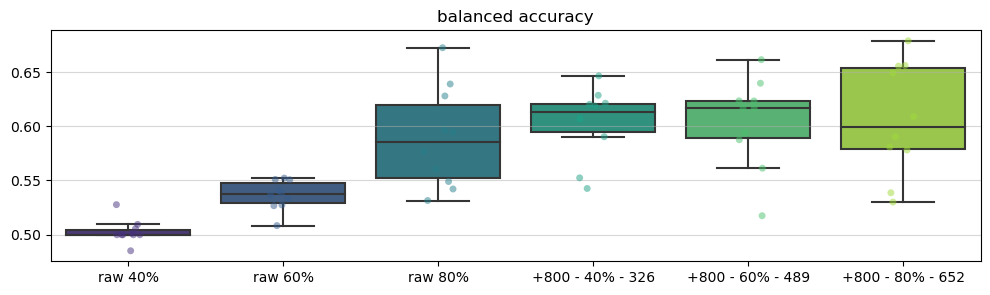

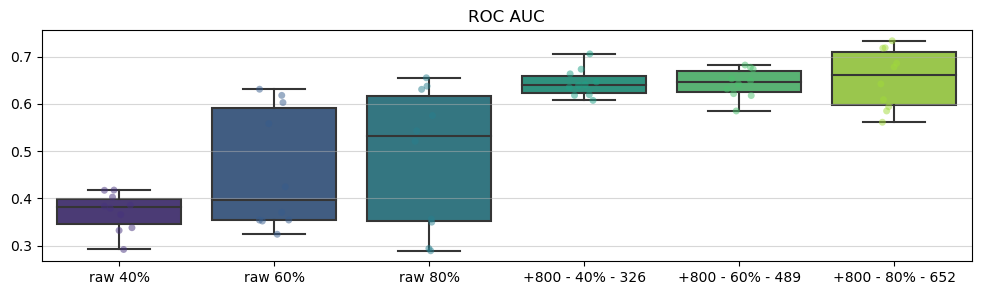

In [120]:
from sklearn.svm import SVC

benchmark_params = {
    'probability':True,
    'kernel':'linear',
    'C':0.1,
    'class_weight':'balanced'
}
compare_plntree_loaders(
    plntree_loaders_list, 
    SVC, benchmark_params, 
    percentile=0.05, 
    save_name=None, 
    display=['balanced accuracy', 'ROC AUC'],
    seed=seed, 
)

Generated batch size: 799


raw 40%        raw 60%        raw 80%  \
accuracy            0.788 (0.013)  0.808 (0.011)  0.816 (0.022)   
precision           0.803 (0.023)  0.824 (0.013)  0.829 (0.022)   
recall              0.788 (0.013)  0.808 (0.011)  0.816 (0.022)   
F1                   0.744 (0.02)  0.774 (0.016)  0.787 (0.031)   
balanced accuracy   0.626 (0.022)  0.661 (0.019)   0.681 (0.04)   
ROC AUC             0.893 (0.014)  0.897 (0.018)   0.91 (0.018)   
PR AUC              0.749 (0.039)  0.781 (0.034)  0.793 (0.032)   
Averaged Precision  0.751 (0.039)  0.782 (0.034)  0.796 (0.032)   

                   +800 - 40% - 326 +800 - 60% - 489 +800 - 80% - 652  
accuracy              0.796 (0.018)     0.82 (0.017)     0.829 (0.03)  
precision             0.786 (0.016)    0.812 (0.019)    0.825 (0.034)  
recall                0.796 (0.018)     0.82 (0.017)     0.829 (0.03)  
F1                    0.783 (0.017)    0.809 (0.019)     0.82 (0.033)  
balanced accuracy     0.698 (0.023)    0.727 (0.026)    0.748 (0.046)  
ROC AUC               0.847 (0.017)    0.873 (0.019)    0.891 (0.021)  
PR AUC                0.666 (0.028)    0.719 (0.022)     0.75 (0.042)  
Averaged Precision    0.668 (0.027)    0.721 (0.022)    0.753 (0.041)

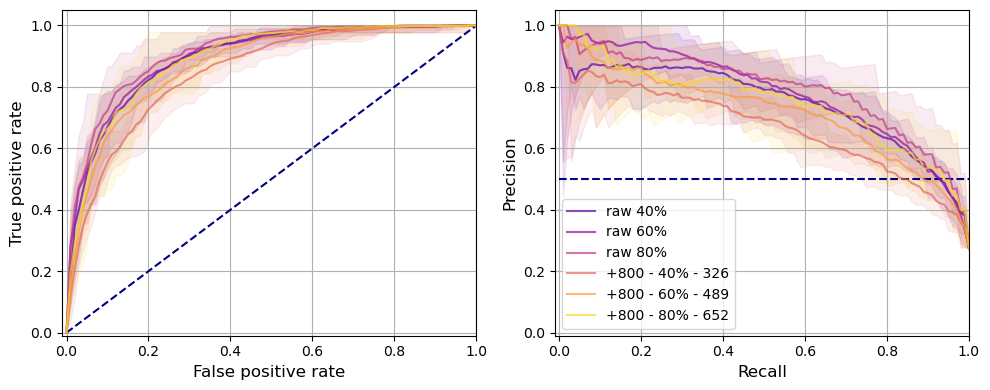

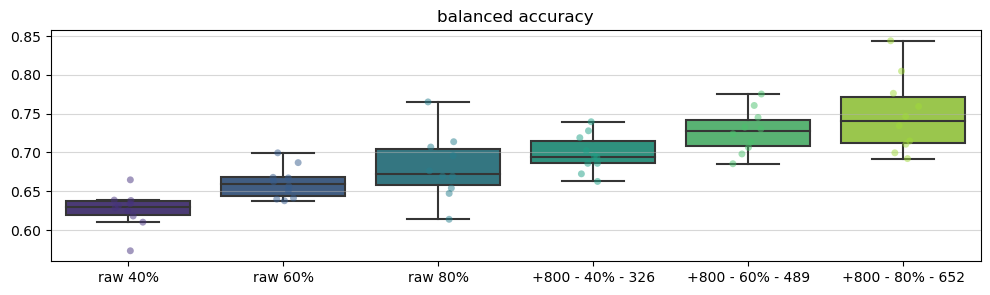

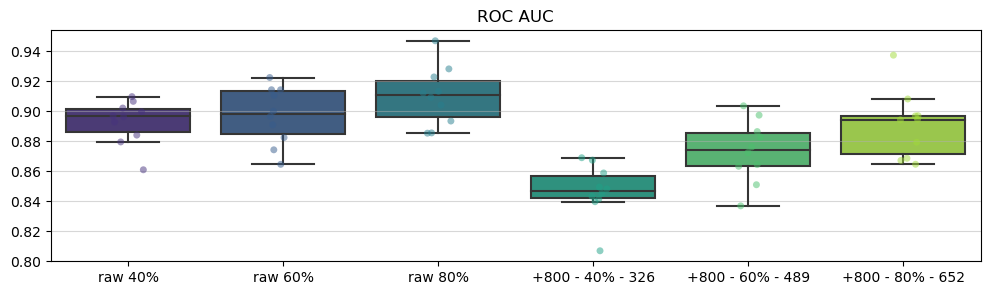

In [121]:
from sklearn.ensemble import RandomForestClassifier
benchmark_params = {
    'n_estimators':1000,
    'class_weight':'balanced'
}
compare_plntree_loaders(
    plntree_loaders_list, 
    RandomForestClassifier, benchmark_params,  
    percentile=0.05, 
    save_name=None, 
    display=['balanced accuracy', 'ROC AUC'],
    seed=seed, 
)

Generated batch size: 799


raw 40%        raw 60%        raw 80%  \
accuracy            0.769 (0.013)  0.779 (0.018)  0.783 (0.033)   
precision           0.759 (0.014)  0.771 (0.018)  0.781 (0.027)   
recall              0.769 (0.013)  0.779 (0.018)  0.783 (0.033)   
F1                  0.762 (0.014)  0.772 (0.017)  0.778 (0.029)   
balanced accuracy   0.685 (0.019)   0.697 (0.02)  0.711 (0.029)   
ROC AUC              0.75 (0.028)   0.77 (0.032)  0.792 (0.035)   
PR AUC               0.579 (0.04)  0.599 (0.033)  0.627 (0.068)   
Averaged Precision   0.582 (0.04)  0.604 (0.032)  0.635 (0.065)   

                   +800 - 40% - 326 +800 - 60% - 489 +800 - 80% - 652  
accuracy              0.748 (0.029)    0.757 (0.017)     0.77 (0.029)  
precision             0.761 (0.014)     0.766 (0.02)     0.778 (0.03)  
recall                0.748 (0.029)    0.757 (0.017)     0.77 (0.029)  
F1                    0.752 (0.023)    0.761 (0.018)    0.771 (0.028)  
balanced accuracy     0.701 (0.015)    0.711 (0.029)    0.724 (0.042)  
ROC AUC               0.767 (0.025)    0.777 (0.025)    0.799 (0.042)  
PR AUC                0.545 (0.045)    0.585 (0.053)    0.609 (0.066)  
Averaged Precision    0.548 (0.045)     0.59 (0.052)    0.617 (0.064)

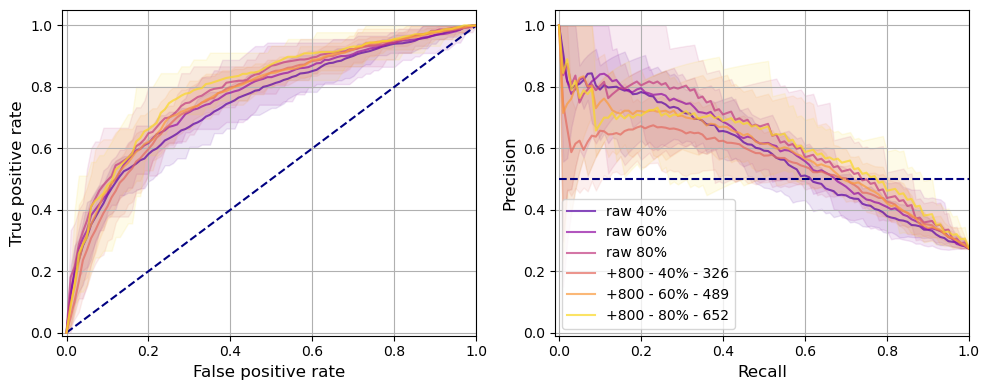

In [122]:
from sklearn.neural_network import MLPClassifier

benchmark_params = {
    'hidden_layer_sizes':(256, 256, 124),
}
compare_plntree_loaders(
    plntree_loaders_list, 
    MLPClassifier, benchmark_params,  
    percentile=0.05, 
    save_name=None, 
    display=['balanced accuracy', 'ROC AUC'],
    seed=seed, 
)

### Balancing augmentation with 80% of training dataset

In [98]:
print('Proportion of label 1 individuals:', np.round(100 * Y_base.sum() / len(Y_base), 1))

Proportion of label 1 individuals: 27.4


In [99]:
train_size = 0.8
prop_y_1 = Y_base.sum() / len(Y_base)
augment_balance = int((1 - 2 * prop_y_1) * len(Y_base) * train_size)
print('Number of label 1 to augment and have parity:', augment_balance)

Number of label 1 to augment and have parity: 295


In [100]:
plntree_loaders = plntree_loaders_list[0.8]

In [109]:
def benchmarks_data_builder(plntree_loaders, seed=seed):
    seed_all(seed)
    builder = {}
    def add_build(name, entry):
        if name not in builder:
            builder[name] = []
        builder[name].append(list(entry))
    for fold, (backward, X_train, y_train, X_test, y_test) in enumerate(plntree_loaders):
        add_build('raw', (X_train, y_train, X_test, y_test))
        X_balanced, y_balanced = augment(X_train, y_train, 1, augment_balance, backward)
        add_build('balanced', (X_balanced, y_balanced, X_test, y_test))
        add_build('balanced + 400', (*augment_all(X_balanced, y_balanced, 200, backward), X_test, y_test))
        add_build('balanced + 800', (*augment_all(X_balanced, y_balanced, 400, backward), X_test, y_test))
        add_build('balanced + 1500', (*augment_all(X_balanced, y_balanced, 750, backward), X_test, y_test))
        add_build(f'+{augment_balance}', (*augment_all(X_train, y_train, augment_balance//2, backward), X_test, y_test))
        add_build(f'+{400+augment_balance}', (*augment_all(X_train, y_train, 200+augment_balance//2, backward), X_test, y_test))
        add_build(f'+{800+augment_balance}', (*augment_all(X_train, y_train, 400+augment_balance//2, backward), X_test, y_test))
        add_build(f'+{1500+augment_balance}', (*augment_all(X_train, y_train, 750+augment_balance//2, backward), X_test, y_test))
    return builder

Generated batch size: 399


raw       balanced balanced + 400  \
accuracy             0.642 (0.05)  0.623 (0.047)  0.648 (0.047)   
precision           0.701 (0.039)   0.69 (0.033)  0.701 (0.038)   
recall               0.642 (0.05)  0.623 (0.047)  0.648 (0.047)   
F1                  0.659 (0.046)  0.639 (0.043)  0.663 (0.044)   
balanced accuracy   0.631 (0.051)  0.615 (0.043)  0.631 (0.051)   
ROC AUC             0.682 (0.053)  0.669 (0.053)   0.68 (0.058)   
PR AUC              0.442 (0.071)  0.442 (0.075)  0.459 (0.082)   
Averaged Precision  0.454 (0.069)  0.453 (0.073)  0.469 (0.081)   

                   balanced + 800 balanced + 1500           +295  \
accuracy            0.646 (0.051)    0.66 (0.053)  0.648 (0.047)   
precision           0.695 (0.035)   0.702 (0.042)    0.7 (0.038)   
recall              0.646 (0.051)    0.66 (0.053)  0.648 (0.047)   
F1                   0.66 (0.046)   0.671 (0.049)  0.662 (0.043)   
balanced accuracy   0.622 (0.046)   0.632 (0.056)   0.63 (0.049)   
ROC AUC             0.684 (0.055)   0.684 (0.059)  0.678 (0.054)   
PR AUC               0.454 (0.08)   0.454 (0.078)  0.451 (0.078)   
Averaged Precision  0.465 (0.079)   0.466 (0.078)  0.462 (0.076)   

                             +695          +1095          +1795  
accuracy            0.655 (0.049)  0.656 (0.052)  0.658 (0.052)  
precision           0.701 (0.039)    0.7 (0.036)  0.696 (0.047)  
recall              0.655 (0.049)  0.656 (0.052)  0.658 (0.052)  
F1                  0.669 (0.045)  0.668 (0.048)  0.669 (0.049)  
balanced accuracy   0.631 (0.052)   0.63 (0.048)  0.625 (0.061)  
ROC AUC             0.685 (0.054)  0.681 (0.053)  0.689 (0.055)  
PR AUC              0.457 (0.073)   0.464 (0.08)  0.455 (0.076)  
Averaged Precision  0.467 (0.073)  0.474 (0.079)  0.467 (0.077)

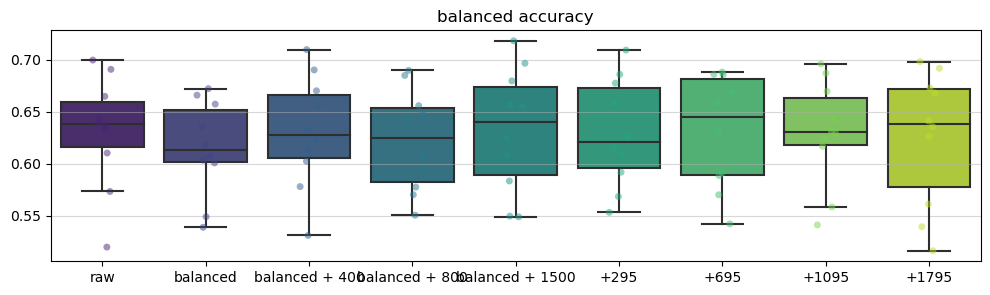

In [110]:
from sklearn.linear_model import LogisticRegression

benchmark_params = {'class_weight':'balanced'}
multiple_performances_summary(
    plntree_loaders, 
    LogisticRegression, benchmark_params, 
    percentile=0.05, 
    save_name=None,
    display=['balanced accuracy', 'ROC AUC'],
    seed=seed, 
)

In [111]:
from sklearn.svm import SVC

benchmark_params = {
    'probability':True,
    'kernel':'linear',
    'C':0.1,
    'class_weight':'balanced'
}
multiple_performances_summary(
    plntree_loaders, 
    SVC, benchmark_params, 
    percentile=0.05, 
    save_name=None, 
    display=['balanced accuracy', 'ROC AUC'],
    seed=seed, 
)

Generated batch size: 399


raw       balanced balanced + 400  \
accuracy            0.584 (0.074)  0.556 (0.108)  0.593 (0.102)   
precision           0.679 (0.039)  0.673 (0.036)  0.685 (0.033)   
recall              0.584 (0.074)  0.556 (0.108)  0.593 (0.102)   
F1                  0.594 (0.083)  0.562 (0.126)    0.6 (0.116)   
balanced accuracy   0.589 (0.044)   0.58 (0.046)  0.599 (0.047)   
ROC AUC             0.556 (0.129)  0.634 (0.056)  0.644 (0.059)   
PR AUC              0.337 (0.081)   0.401 (0.06)  0.411 (0.068)   
Averaged Precision  0.348 (0.082)  0.411 (0.058)  0.423 (0.067)   

                   balanced + 800 balanced + 1500           +295  \
accuracy            0.614 (0.089)   0.625 (0.081)  0.591 (0.095)   
precision            0.69 (0.029)    0.69 (0.028)  0.676 (0.033)   
recall              0.614 (0.089)   0.625 (0.081)  0.591 (0.095)   
F1                  0.623 (0.099)   0.634 (0.084)  0.602 (0.097)   
balanced accuracy   0.608 (0.041)    0.611 (0.04)  0.591 (0.045)   
ROC AUC             0.647 (0.055)    0.652 (0.06)  0.632 (0.053)   
PR AUC              0.412 (0.061)   0.423 (0.073)   0.394 (0.06)   
Averaged Precision  0.424 (0.061)   0.435 (0.072)   0.405 (0.06)   

                             +695          +1095          +1795  
accuracy            0.615 (0.074)  0.615 (0.089)   0.65 (0.059)  
precision           0.682 (0.028)  0.692 (0.029)  0.692 (0.038)  
recall              0.615 (0.074)  0.615 (0.089)   0.65 (0.059)  
F1                  0.627 (0.074)  0.623 (0.089)  0.655 (0.051)  
balanced accuracy   0.601 (0.038)  0.608 (0.038)  0.613 (0.054)  
ROC AUC             0.646 (0.055)  0.648 (0.056)   0.65 (0.056)  
PR AUC              0.409 (0.064)   0.42 (0.071)  0.412 (0.066)  
Averaged Precision   0.42 (0.063)   0.431 (0.07)  0.423 (0.065)

Generated batch size: 399


raw       balanced balanced + 400  \
accuracy            0.811 (0.021)  0.832 (0.014)   0.831 (0.02)   
precision            0.826 (0.02)  0.828 (0.016)  0.827 (0.022)   
recall              0.811 (0.021)  0.832 (0.014)   0.831 (0.02)   
F1                  0.779 (0.031)  0.821 (0.017)  0.821 (0.023)   
balanced accuracy    0.672 (0.04)  0.743 (0.029)  0.745 (0.036)   
ROC AUC             0.909 (0.019)  0.891 (0.016)  0.894 (0.016)   
PR AUC               0.793 (0.03)  0.772 (0.021)  0.768 (0.036)   
Averaged Precision   0.796 (0.03)  0.774 (0.021)  0.771 (0.035)   

                   balanced + 800 balanced + 1500           +295  \
accuracy            0.837 (0.019)    0.83 (0.021)  0.833 (0.019)   
precision           0.833 (0.021)   0.827 (0.022)   0.835 (0.02)   
recall              0.837 (0.019)    0.83 (0.021)  0.833 (0.019)   
F1                  0.828 (0.021)   0.824 (0.022)  0.817 (0.024)   
balanced accuracy   0.757 (0.032)   0.762 (0.033)  0.728 (0.037)   
ROC AUC             0.894 (0.017)   0.889 (0.019)  0.907 (0.015)   
PR AUC              0.763 (0.037)   0.755 (0.041)  0.788 (0.029)   
Averaged Precision  0.767 (0.036)    0.759 (0.04)   0.79 (0.028)   

                             +695          +1095          +1795  
accuracy            0.824 (0.029)  0.825 (0.022)  0.833 (0.027)  
precision           0.821 (0.033)  0.822 (0.026)   0.829 (0.03)  
recall              0.824 (0.029)  0.825 (0.022)  0.833 (0.027)  
F1                  0.807 (0.036)   0.81 (0.025)   0.825 (0.03)  
balanced accuracy    0.72 (0.052)  0.723 (0.035)  0.754 (0.044)  
ROC AUC              0.902 (0.02)  0.894 (0.025)  0.892 (0.022)  
PR AUC               0.775 (0.04)  0.761 (0.049)  0.754 (0.044)  
Averaged Precision   0.779 (0.04)  0.765 (0.047)  0.758 (0.043)

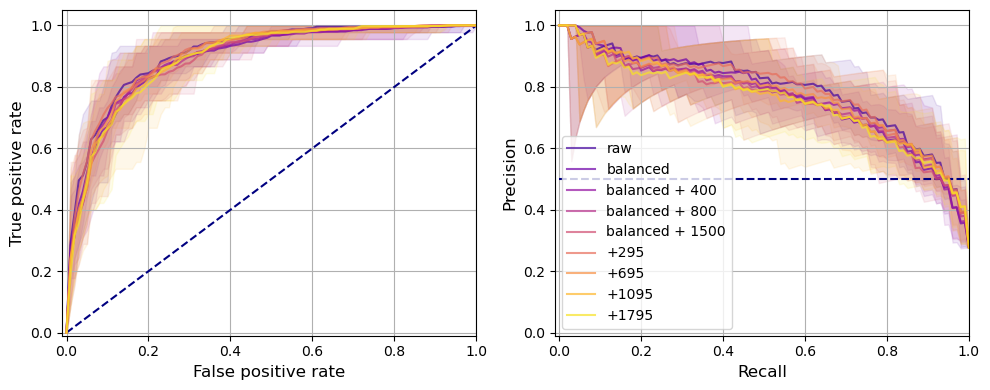

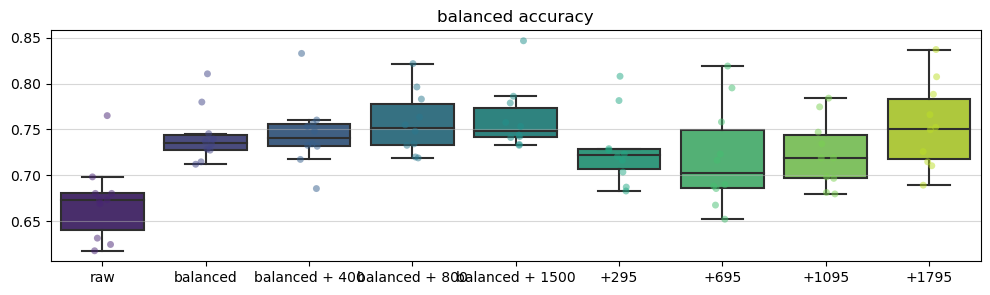

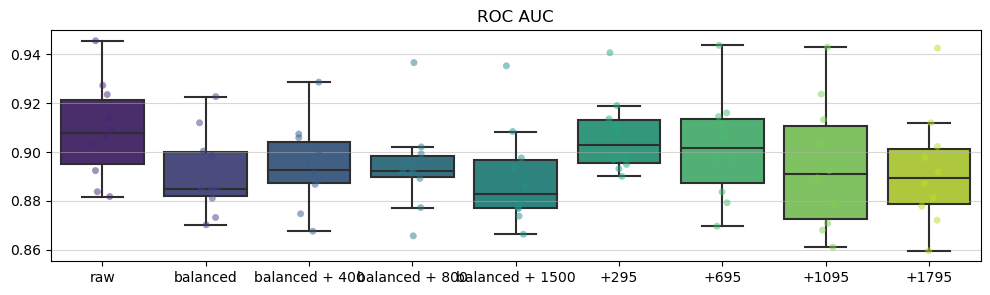

In [112]:
from sklearn.ensemble import RandomForestClassifier
benchmark_params = {
    'n_estimators':1000,
    'class_weight':'balanced'
}
multiple_performances_summary(
    plntree_loaders, 
    RandomForestClassifier, benchmark_params, 
    percentile=0.05, 
    save_name=None, 
    display=['balanced accuracy', 'ROC AUC'],
    seed=seed, 
)

Generated batch size: 399


raw       balanced balanced + 400  \
accuracy            0.779 (0.031)  0.739 (0.023)  0.747 (0.027)   
precision            0.78 (0.027)  0.774 (0.024)  0.768 (0.022)   
recall              0.779 (0.031)  0.739 (0.023)  0.747 (0.027)   
F1                  0.775 (0.027)  0.749 (0.022)  0.754 (0.024)   
balanced accuracy   0.711 (0.032)  0.728 (0.033)  0.717 (0.027)   
ROC AUC             0.792 (0.038)  0.808 (0.032)  0.774 (0.033)   
PR AUC              0.624 (0.077)  0.606 (0.053)  0.579 (0.053)   
Averaged Precision  0.633 (0.073)   0.614 (0.05)   0.589 (0.05)   

                   balanced + 800 balanced + 1500           +295  \
accuracy             0.77 (0.022)   0.779 (0.027)  0.787 (0.023)   
precision           0.783 (0.017)   0.791 (0.019)  0.786 (0.019)   
recall               0.77 (0.022)   0.779 (0.027)  0.787 (0.023)   
F1                   0.773 (0.02)   0.783 (0.024)  0.784 (0.021)   
balanced accuracy   0.733 (0.026)   0.744 (0.021)  0.723 (0.028)   
ROC AUC             0.813 (0.028)   0.806 (0.035)  0.804 (0.028)   
PR AUC              0.628 (0.047)    0.63 (0.066)  0.646 (0.063)   
Averaged Precision  0.637 (0.045)   0.636 (0.064)  0.653 (0.059)   

                             +695          +1095          +1795  
accuracy            0.779 (0.018)   0.769 (0.04)  0.779 (0.029)  
precision           0.777 (0.017)  0.782 (0.031)  0.785 (0.026)  
recall              0.779 (0.018)   0.769 (0.04)  0.779 (0.029)  
F1                  0.776 (0.017)   0.77 (0.034)   0.78 (0.027)  
balanced accuracy   0.716 (0.023)   0.72 (0.034)  0.729 (0.034)  
ROC AUC             0.792 (0.015)  0.794 (0.034)  0.798 (0.034)  
PR AUC              0.611 (0.038)   0.63 (0.074)  0.624 (0.075)  
Averaged Precision  0.618 (0.036)  0.636 (0.071)   0.63 (0.074)

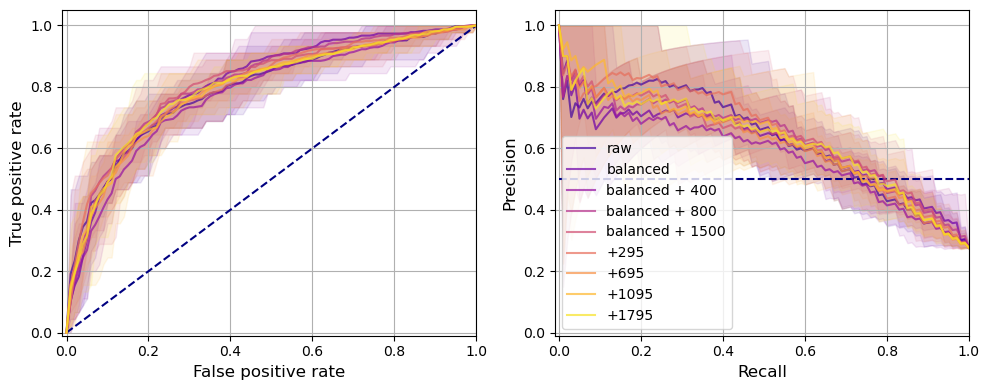

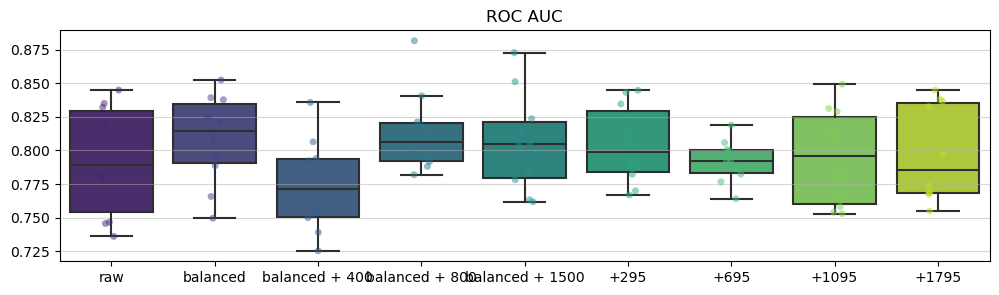

In [113]:
from sklearn.neural_network import MLPClassifier

benchmark_params = {
    'hidden_layer_sizes':(256, 256, 124),
}
multiple_performances_summary(
    plntree_loaders, 
    MLPClassifier, benchmark_params, 
    percentile=0.05, 
    save_name=None, 
    display=['balanced accuracy', 'ROC AUC'],
    seed=seed, 
)